# RICH AI Exploratory Data Analysis

### Notes
- Labels are 0: Muon, 1: Pion, 2: Positron
- Likelihood labels are different [Pion, Muon, Positron]

### TODO

- Add more data
- Ring centre alignment still off

In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob

# Helper functions

In [2]:
def read_RICHAI_data(file_paths):
    """Read in all the 2018 RICHAI data
    
    Parameters
    ----------
    file_paths : list of str
        List of file paths of all data sets.
        
    Returns
    -------
    data_files : dict
        Dictionary of HFD data sets     
    """
    data_files = {}
    for file_path in file_paths:
        name = file_path.split("/")[4] + "/" + file_path.split("/")[5].split(".")[0]
        data_files[name] = h5py.File(file_path)
    
    return data_files

In [3]:
def events_to_pandas(dfile):
    """Convert HDF5 events data to Pandas
    
    Parameters
    ----------
    dfile : HDF5 file
        The RICHAI HDF5 file to convert to pandas.
        
    Returns
    -------
    df : pd.DataFrame
        pandas DataFrame with Events data
    """
    
    df = pd.DataFrame()
    
    # event features
    df["run_id"] = dfile["Events"]["run_id"]
    df["burst_id"] = dfile["Events"]["burst_id"]
    df["event_id"] = dfile["Events"]["event_id"]
    df["track_id"] = dfile["Events"]["track_id"]
    df["track_momentum"] = dfile["Events"]["track_momentum"]
    df["chod_time"] = dfile["Events"]["chod_time"]
    df["ring_radius"] = dfile["Events"]["ring_radius"]
    df["ring_centre_pos_x"] = dfile["Events"]["ring_centre_pos"][:, 0]
    df["ring_centre_pos_y"] = dfile["Events"]["ring_centre_pos"][:, 1]
    df["ring_likelihood_pion"] = dfile["Events"]["ring_likelihood"][:, 0]
    df["ring_likelihood_muon"] = dfile["Events"]["ring_likelihood"][:, 1]
    df["ring_likelihood_positron"] = dfile["Events"]["ring_likelihood"][:, 2]
    
    # labels
    mu_off = dfile.attrs["muon_offset"]
    pi_off = dfile.attrs["pion_offset"]
    pos_off = dfile.attrs["positron_offset"]
    entries = dfile.attrs["entries"]
    
    labels = np.zeros(entries, dtype=np.int32)
    labels[mu_off:pi_off] = 0
    labels[pi_off:pos_off] = 1
    labels[pos_off:] = 2
    
    df["label"] = labels
    
    # hit mapping values
    df["first_hit"] = np.array(dfile["HitMapping"])[:-1]  # hit n
    df["last_hit"] = np.array(dfile["HitMapping"])[1:]    # hit n + 1
    df["total_hits"] = df["last_hit"] - df["first_hit"]
    
    return df

In [4]:
def get_string_label(label):
    """Add string label to pandas df (to be used with map)"""
    if label == 0:
        return "muon"
    elif label == 1:
        return "pion"
    elif label == 2:
        return "positron"

In [5]:
def compute_seq_id(hit, or_id=0):
    """Compute the RICH PMT sequence ID"""
    disk_id, pm_id, sc_id, up_dw_id, _ = hit
    
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return int(seq_id)

compute_seq_id = np.vectorize(compute_seq_id, otypes=[int])

In [75]:
def realign_x_hits(x, mirror):
    if mirror == 0:
        return x - 146.8
    else:
        return x + 196.7
    
def realign_y_hits(y, mirror):
    if mirror == 0:
        return y - 19.8
    else:
        return y - 9.5

In [7]:
def get_hit_info_df(f, df, event):
    """Get the hit info for an event in a pandas dataframe
    
    Parameters
    ----------
    f : HDF5 file
        The RICHAI HDF5 file.
    df : pandas DataFrame
        A pandas DataFrame representation of the HDF5 Events file.
    event : int
        The event number to get the hit info for.
        
    Returns
    -------
    positions : pd.DataFrame
        pandas DataFrame with hits data for a given event
    """
    positions = []
    
    # get our hit data for this event
    idx_from = df.loc[event]["first_hit"]
    idx_to = df.loc[event]["last_hit"]
    hit_data = f["Hits"][idx_from:idx_to]
    
    # get our pm locations for this event
    for hit in hit_data:
        pm_idx = compute_seq_id(hit)
        positions.append(position_map[pm_idx])
    
    # add hit time, chod time, and delta
    positions = pd.DataFrame(positions, columns=["x", "y", "mirror"])
    positions["x_realigned"] = positions.apply(lambda a: realign_x_hits(a.x, a.mirror), axis=1)
    positions["y_realigned"] = positions.apply(lambda a: realign_y_hits(a.y, a.mirror), axis=1)
    positions["hit_time"] = hit_data["hit_time"]
    positions["chod_time"] = df["chod_time"][event]
    positions["chod_delta"] = positions["hit_time"] - positions["chod_time"]
    positions["class"] = df["class"][event]
    positions["event"] = event
    
    return positions

In [8]:
def draw_pmt_pos(ax,pmt_pos):
    """
        Add circle patches corresponding to the PMT position to the Axes object ax
    """
    for i in pmt_pos:
        if i[2] == 0: # 0: Jura / 1: Salève, PMT disks are identical, we can pick either one. [TODO: CHECK!]
            ax.add_patch(plt.Circle((i[0],i[1]),1.0, color='black'))
    return ax

In [9]:
def get_class_samples(df, n, seed, momentum_bin=None, wide=None):
    """Sample n samples for each particle class from the events dataframe"""
    
    if momentum_bin and wide:
        df = df.query("wide_momentum_bin == @momentum_bin")
        
    if momentum_bin and not wide:
        df = df.query("narrow_momentum_bin == @momentum_bin")
        
    samples = pd.concat(
        [
            df[df["class"] == "muon"].sample(n=n, random_state=seed),
            df[df["class"] == "pion"].sample(n=n, random_state=seed),
            df[df["class"] == "positron"].sample(n=n, random_state=seed)        
        ]

    )
    
    return samples

# Read in data files

In [10]:
file_paths = glob.glob("/data/bvelghe/capstone2022/*/*")
data_files = read_RICHAI_data(file_paths)
data_files.keys()

dict_keys(['A/Run008563', 'A/Run008548', 'A/Run008564', 'A/Run008553', 'A/Run008562', 'C/2018E', 'B/2018B'])

In [11]:
f = data_files['A/Run008563']
f.keys()

<KeysViewHDF5 ['Events', 'HitMapping', 'Hits']>

In [12]:
position_map = np.load("/home/nico/RICHPID/tools/rich_pmt_positions.npy")
position_map.shape

(1952, 3)

# Create `Events` pandas `DataFrame`

In [13]:
df = events_to_pandas(f)

# add class label (text)
df["class"] = df["label"].apply(get_string_label)

# add wide momentum bin
wide_momentum_bins = ['0-9', '10-19', '20-29', '30-39','40+']
df["wide_momentum_bin"] = pd.cut(
    df["track_momentum"],
    [0, 10, 20, 30, 40, np.inf],
    labels=wide_momentum_bins
)

# add narrow momentum bin
narrow_momentum_bins = []

for i in range(0, 40):
    narrow_momentum_bins.append((i, i+1))

narrow_momentum_bins.append((40, np.inf))

df["narrow_momentum_bin"] = pd.cut(
    df["track_momentum"],
    pd.IntervalIndex.from_tuples(narrow_momentum_bins),
    labels=[f"({b[0]}, {b[1]}]" for b in narrow_momentum_bins]
)

df.shape

(181847, 19)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181847 entries, 0 to 181846
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   run_id                    181847 non-null  int32   
 1   burst_id                  181847 non-null  int32   
 2   event_id                  181847 non-null  int64   
 3   track_id                  181847 non-null  int32   
 4   track_momentum            181847 non-null  float32 
 5   chod_time                 181847 non-null  float32 
 6   ring_radius               181846 non-null  float32 
 7   ring_centre_pos_x         181846 non-null  float32 
 8   ring_centre_pos_y         181846 non-null  float32 
 9   ring_likelihood_pion      181847 non-null  float32 
 10  ring_likelihood_muon      181847 non-null  float32 
 11  ring_likelihood_positron  181847 non-null  float32 
 12  label                     181847 non-null  int32   
 13  first_hit                 181

<div class="alert alert-warning">
The very last event has 6m hits?
</div>

In [15]:
# this matches Bob's documentation on https://github.com/TRIUMF-Capstone2022/RICHPID/tree/main/docs
df["class"].value_counts()

muon        162478
pion         17602
positron      1767
Name: class, dtype: int64

# Plot settings

In [16]:
plt.style.use('tableau-colorblind10')

# line styles for positron, pion, muon
lss = ['dashed', 'dashdot', "dotted"]

# Plots: Event Data

## Track momentum

### Momentum histograms - Bins = 1 GeV

- Muon has the widest range, pion a bit narrower.  Positron momentum range is much lower.
- Note positron has less data
- The bins here are a single GeV

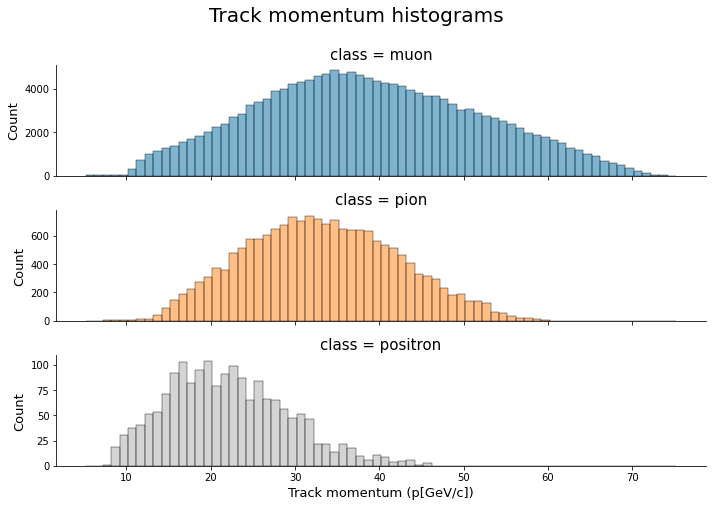

In [17]:
g = sns.displot(
    data=df,
    x="track_momentum",
    col="class",
    hue="class",
    binwidth=1,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
)

g.fig.suptitle("Track momentum histograms", y=1, fontsize=20)
g.set_titles(size=15)
g.set_xlabels("Track momentum (p[GeV/c])", fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

plt.tight_layout()
plt.show()

### Momentum KDE plot

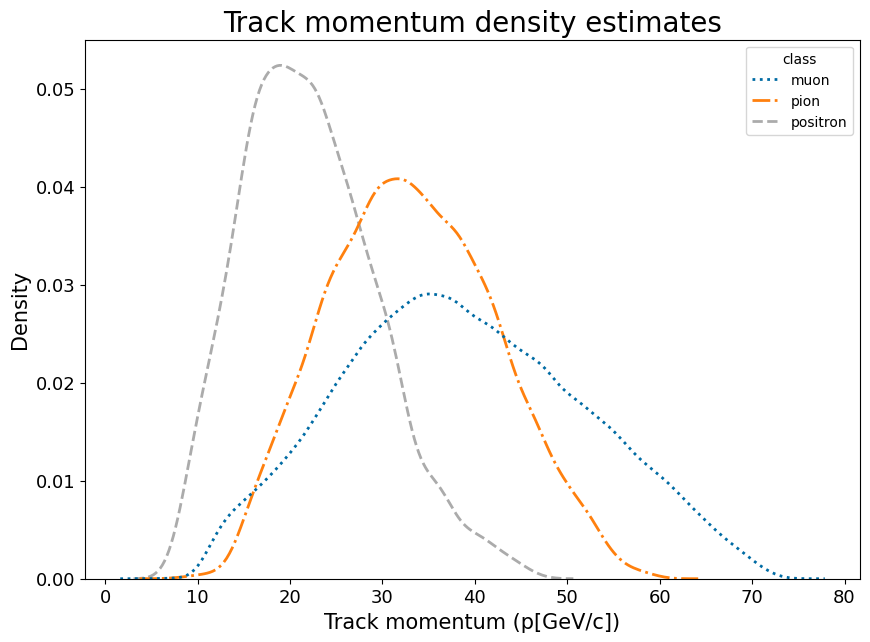

In [18]:
fig = plt.figure(figsize=(10, 7))
g = sns.kdeplot(df["track_momentum"], hue=df["class"], common_norm=False, linewidth=2)

plt.title("Track momentum density estimates", fontsize=20)
plt.xlabel("Track momentum (p[GeV/c])", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

handles = g.legend_.legendHandles[::-1]

for line, ls, handle in zip(g.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)

plt.show()

### Momentum Boxplots

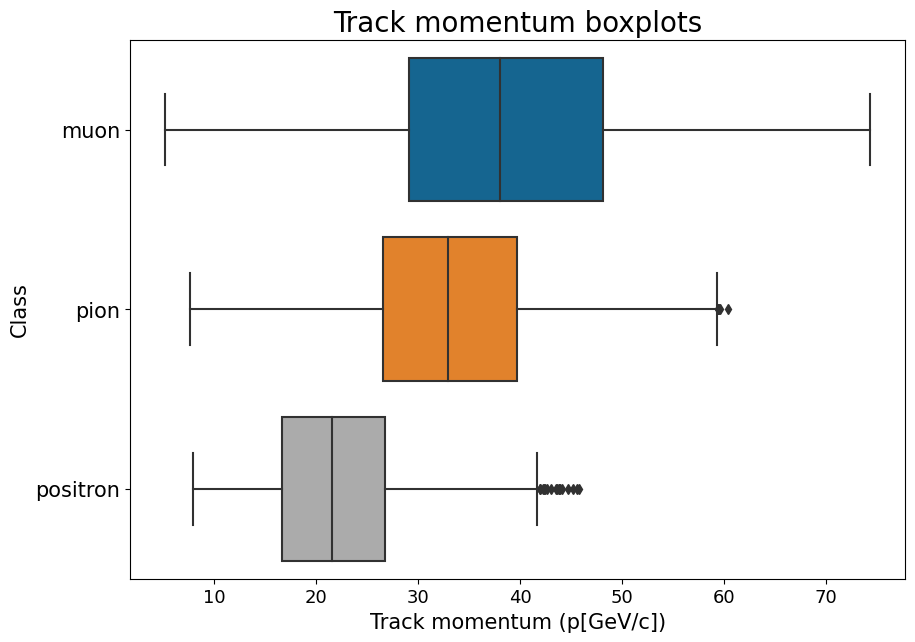

In [19]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="track_momentum", y="class")
plt.title("Track momentum boxplots", fontsize=20)
plt.xlabel("Track momentum (p[GeV/c])", fontsize=15);
plt.ylabel("Class", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=15)
plt.show()

## Ring radius

### MLE errors

<div class="alert alert-info" style="color:black">
Confirmed w/ TRIUMF that ring radii of 999999 represents a failure in the MLE algorithm.
</div>

In [20]:
counts = df[df["ring_radius"] >= 999999.000].shape[0]
print(f"There are {counts} examples with ring radius 999999")

There are 305 examples with ring radius 999999


### Ring radius histograms - bins = 1 GeV

- Axis limits have been cut off here at > 120mm and < 220mm since this helps show plots better.  There is some noise outside of these limits.

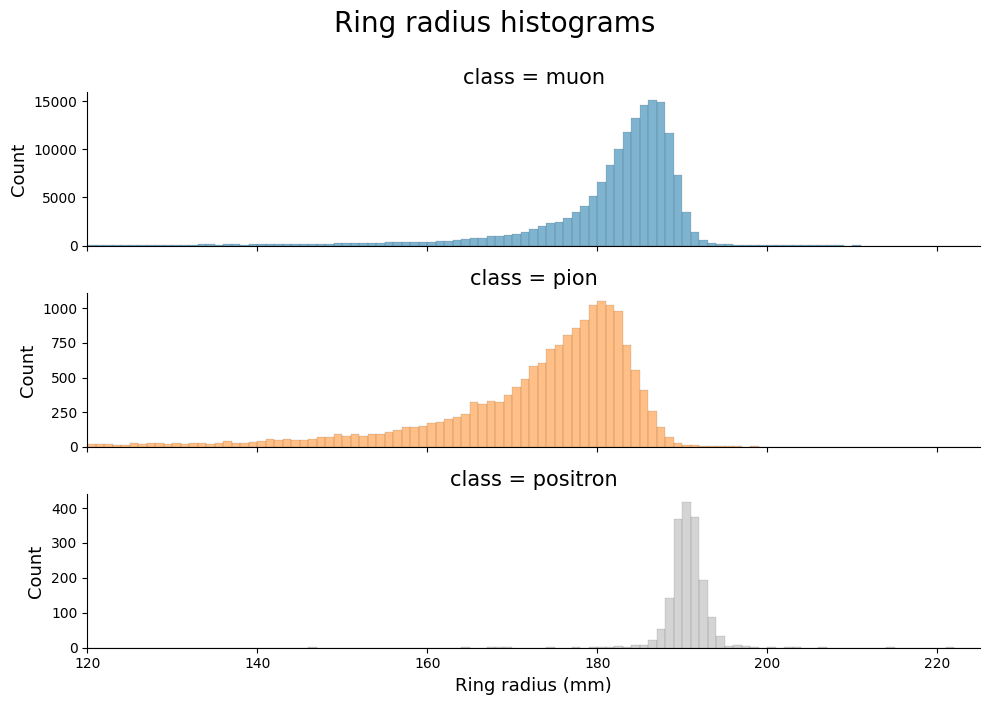

In [21]:
g = sns.displot(
    data=df,
    x=df.query("ring_radius < 999999.000")["ring_radius"],
    col=df.query("ring_radius < 999999.000")["class"],
    hue=df.query("ring_radius < 999999.000")["class"],
    binwidth=1,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
)

g.fig.suptitle("Ring radius histograms", y=1, fontsize=20)
g.set_titles(size=15)
g.set_xlabels("Ring radius (mm)", fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

for ax in g.axes:
    ax.set_xlim(120, 225)
    
plt.tight_layout()
plt.show()

### Ring Radius KDE Plots

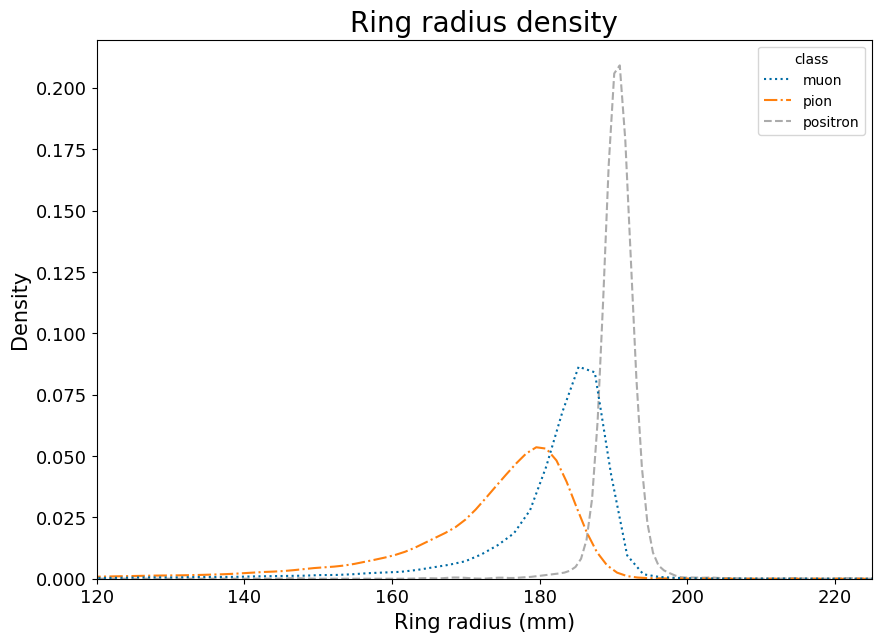

In [22]:
plt.figure(figsize=(10, 7))
g = sns.kdeplot(
    x=df.query("ring_radius < 999999.000")["ring_radius"],
    hue=df.query("ring_radius < 999999.000")["class"],
    common_norm=False,
)

plt.title("Ring radius density", fontsize=20)
plt.xlabel("Ring radius (mm)", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(120, 225)

handles = g.legend_.legendHandles[::-1]

for line, ls, handle in zip(g.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)


plt.show()

## Distribution of ring radius for momentum bins of 1 GeV

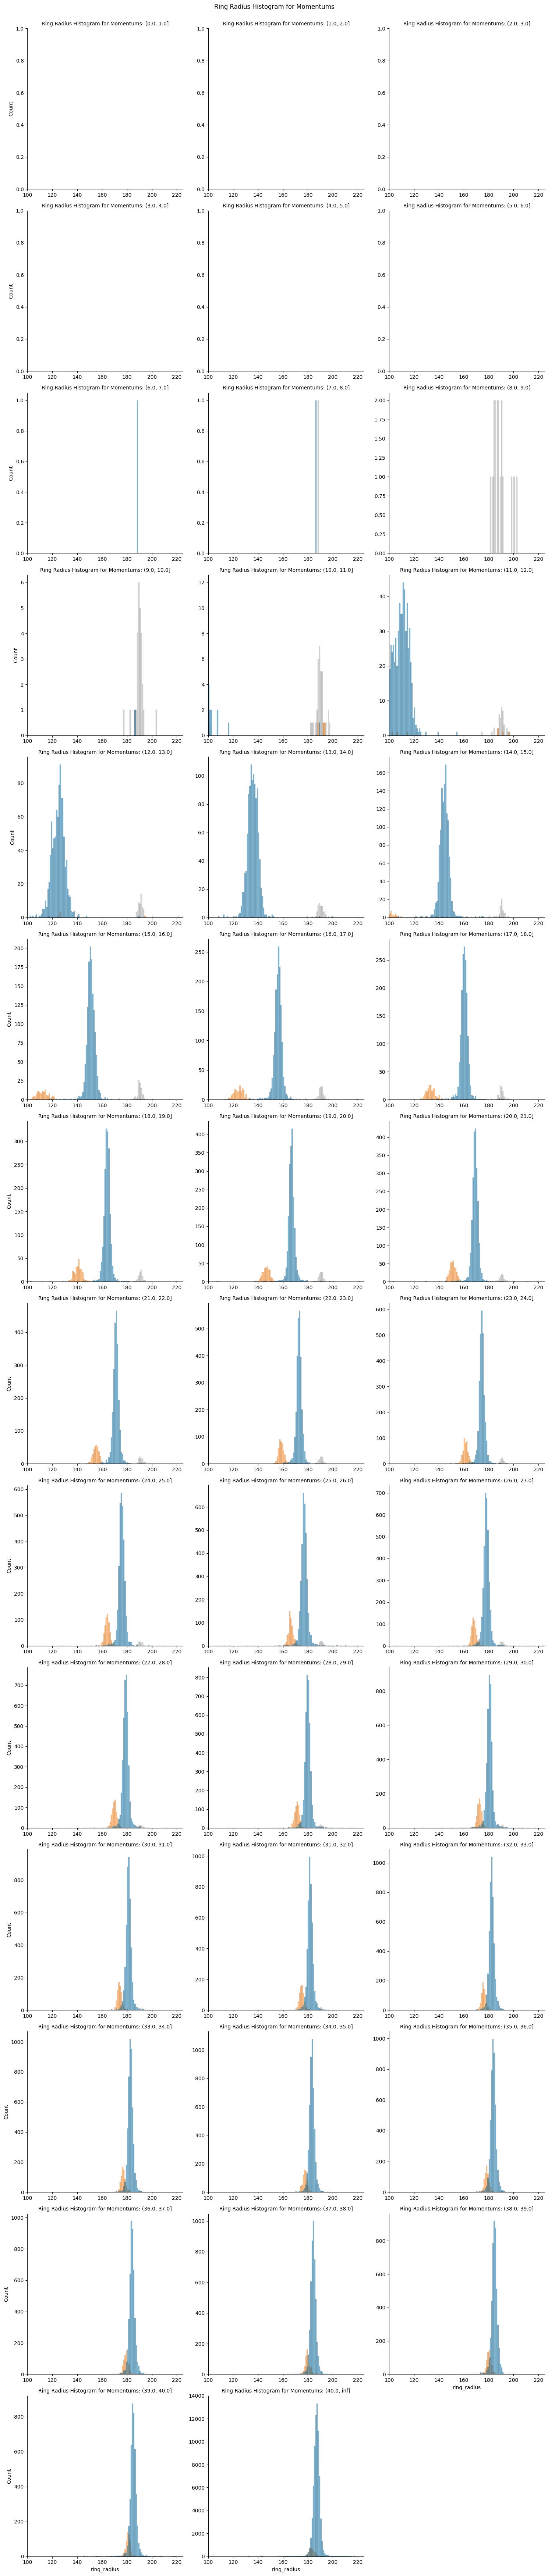

In [23]:
g = sns.displot(
    data=df.query("ring_radius < 999999.000"),
    x="ring_radius",
    col="narrow_momentum_bin",
    hue="class",
    col_wrap=3,
    facet_kws=dict(sharey=False, sharex=False),
    binwidth=1,
    legend=False
);

for ax in g.axes:
    ax.set_xlim(100, 225)

g.set_titles("Ring Radius Histogram for Momentums: {col_name}")
g.fig.suptitle("Ring Radius Histogram for Momentums", y=1)
g.tight_layout()

plt.show()

<!-- ## Location of Ring Centres for Each Particle -->

## Ring centre locations for each particle

- Some patterns observed in locations of ring centres, but based on discussion w/ Bob this is biased.

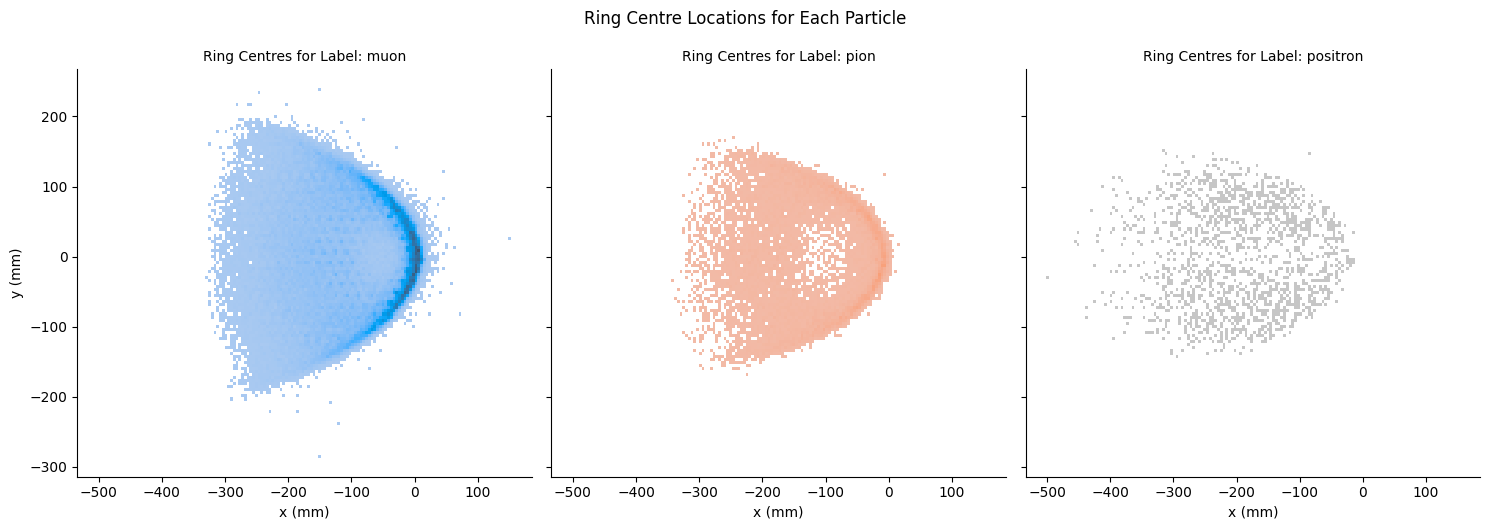

In [24]:
g = sns.displot(
    x=df.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_x"],
    y=df.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_y"],
    col=df.query("ring_centre_pos_y < 500000.000")["class"],
    hue=df.query("ring_centre_pos_y < 500000.000")["class"],
    legend=False,
    col_wrap=3
);

g.fig.set_figheight(5)
g.fig.set_figwidth(15)
g.set_axis_labels("x (mm)", "y (mm)")
g.set_titles("Ring Centres for Label: {col_name}")
g.tight_layout()
g.fig.suptitle("Ring Centre Locations for Each Particle", y=1.05)
plt.show()

## Track momentum vs. Ring radius

- We can see separation in the plot from about 10GeV to 40 GeV

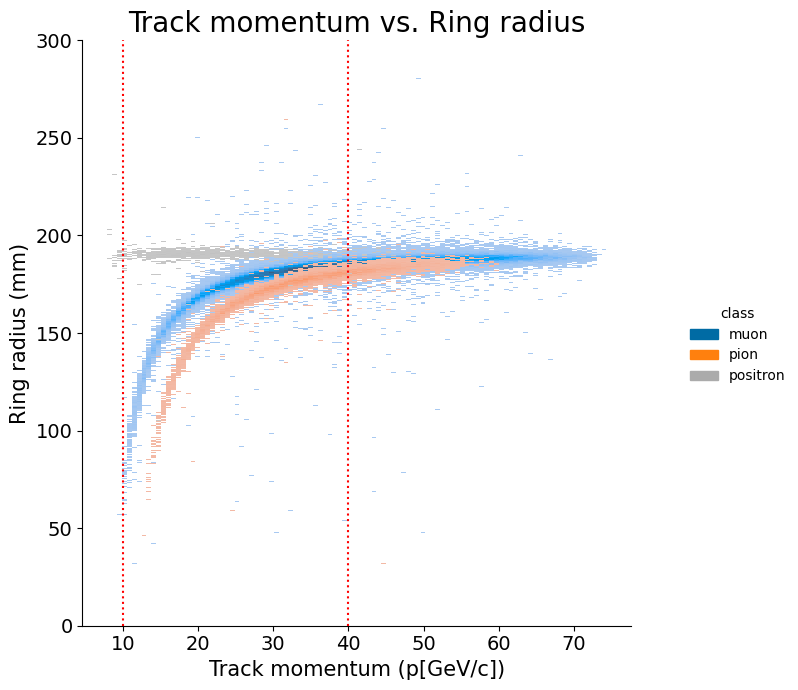

In [25]:
g = sns.displot(
    x=df.query("ring_centre_pos_y < 500000.000")["track_momentum"],
    y=df.query("ring_centre_pos_y < 500000.000")["ring_radius"],
    hue=df.query("ring_centre_pos_y < 500000.000")["class"],
);


g.ax.set_title("Track momentum vs. Ring radius", fontsize=20)
g.set_axis_labels("Track momentum (p[GeV/c])", "Ring radius (mm)", fontsize=15)
g.set_titles("Ring Centres for Label: {col_name}")
g.ax.tick_params(axis='x', labelsize= 14)
g.ax.tick_params(axis='y', labelsize= 14)
g.ax.set_ylim([0, 300])    # some noise above 300 makes the plot ugly
g.fig.set_figheight(7)
g.fig.set_figwidth(8)
g.tight_layout()

plt.axvline(10, color="red", linestyle="dotted")
plt.axvline(40, color="red", linestyle="dotted")

plt.show()

# Plots: Hits Data

## Note - bug in last hit in `HitMapping`

<div class="alert alert-info" style="color:black">
Confirmed w/ TRIUMF that there is a bug in the code for the last hit mapping value.
</div>

In [26]:
f["HitMapping"][-2]

82214

In [27]:
f["HitMapping"][-1]

6856199

In [28]:
len(f["Hits"][f["HitMapping"][-2]:f["HitMapping"][-1]])

6773985

## Note - some events have no hits

<div class="alert alert-info" style="color:black">
Confirmed w/ TRIUMF that sometimes there may be no hits for an event.
</div>

In [29]:
df.query("total_hits < 0")

run_id  burst_id  event_id  track_id  track_momentum  chod_time  \
162477    8563        10   2127576         0       45.107151   5.858219   
180079    8563        10   2100708         0       27.119833  11.933970   

        ring_radius  ring_centre_pos_x  ring_centre_pos_y  \
162477   186.400986         -35.000172          73.605415   
180079   172.741959        -100.906670         105.466911   

        ring_likelihood_pion  ring_likelihood_muon  ring_likelihood_positron  \
162477                   1.0              0.003610              1.674357e-08   
180079                   1.0              0.007288              2.956682e-20   

        label  first_hit  last_hit  total_hits class wide_momentum_bin  \
162477      0    6081777         0    -6081777  muon               40+   
180079      1     692122         0     -692122  pion             20-29   

       narrow_momentum_bin  
162477         (40.0, inf]  
180079        (27.0, 28.0]

In [30]:
f["HitMapping"][162477]

6081777

In [31]:
f["HitMapping"][162478]

0

In [32]:
f["HitMapping"][180079]

692122

In [33]:
f["HitMapping"][180080]

0

In [34]:
# remove the last row of the df due to problems discussed prior
hits_df = df.iloc[:-1, :]

# only plot positive number of hits for problems discussed prior
hits_df = hits_df.query("total_hits > 0")

## Histograms of Total # of Hits by Particle

- Axis cut off at 200 here, there are some events with more hits but very few.

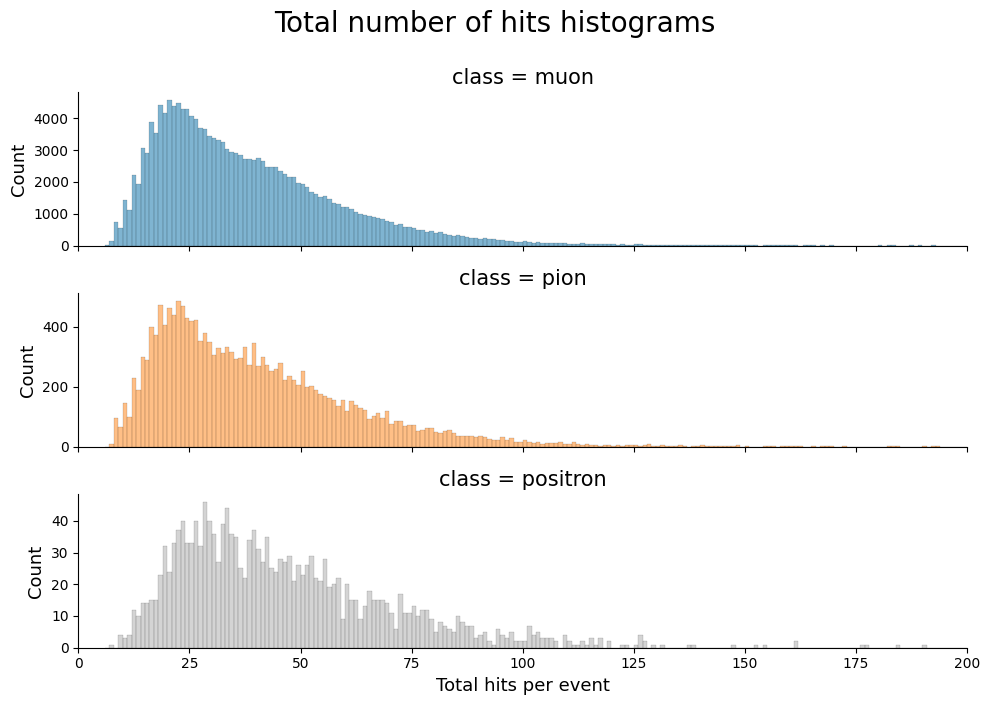

In [35]:
g = sns.displot(
    data=hits_df,
    x="total_hits",
    col="class",
    hue="class",
    binwidth=1,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
)

g.fig.suptitle("Total number of hits histograms", y=1, fontsize=20)
g.set_titles(size=15)
g.set_xlabels("Total hits per event", fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

for ax in g.axes:
    ax.set_xlim(0, 200)
    
plt.tight_layout()
plt.show()

## Boxplots of Total # of Hits by Particle

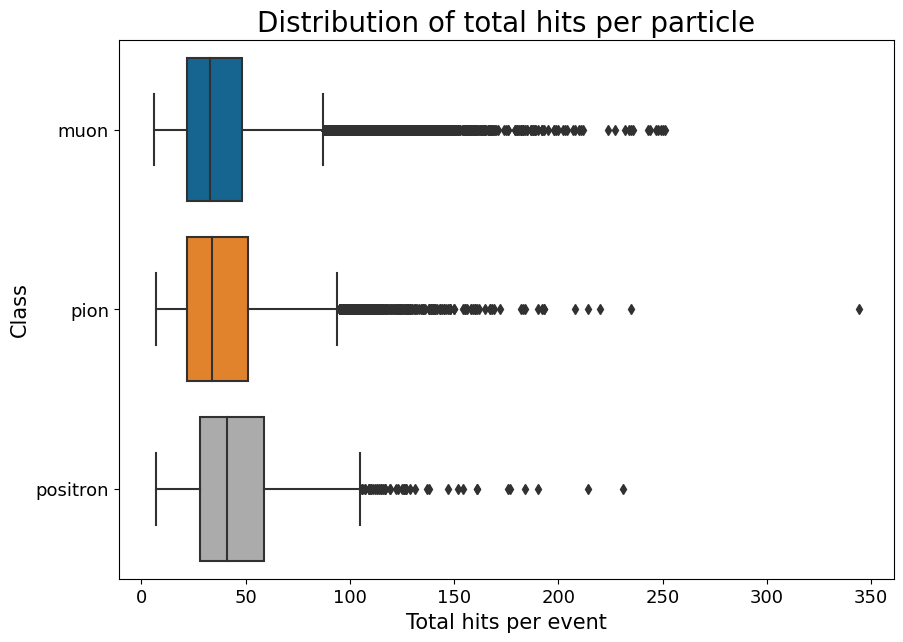

In [36]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=hits_df, x="total_hits", y="class")
plt.title("Distribution of total hits per particle", fontsize=20)
plt.xlabel("Total hits per event", fontsize=15);
plt.ylabel("Class", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

## Distribution of hit time deltas (hit - chod) for 25 events for each particle

- Red line is zero
- Muons look OK, pion and positron to discuss...

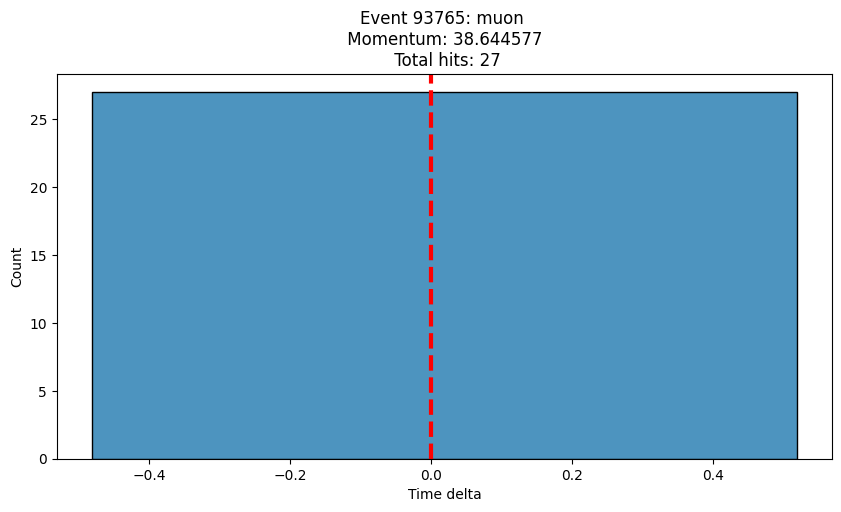

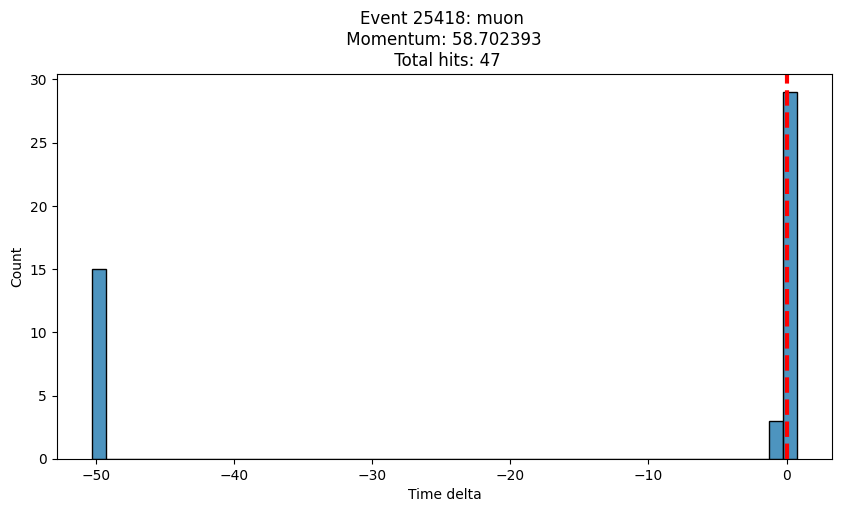

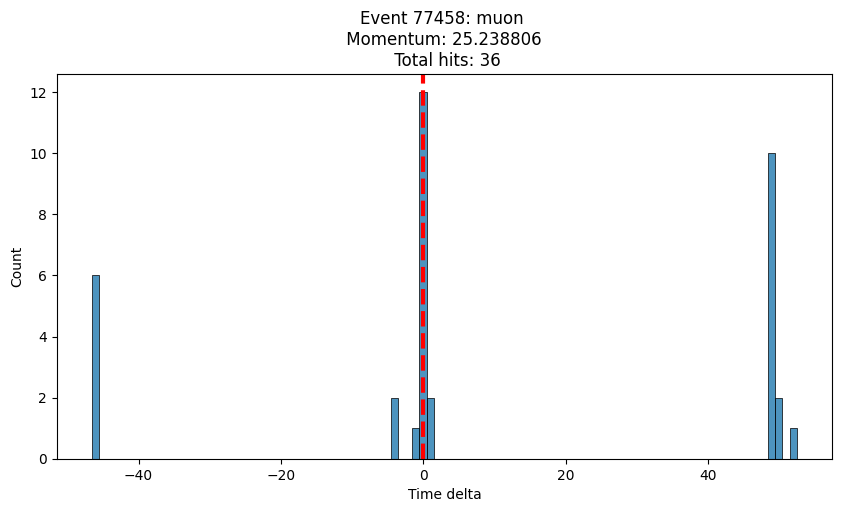

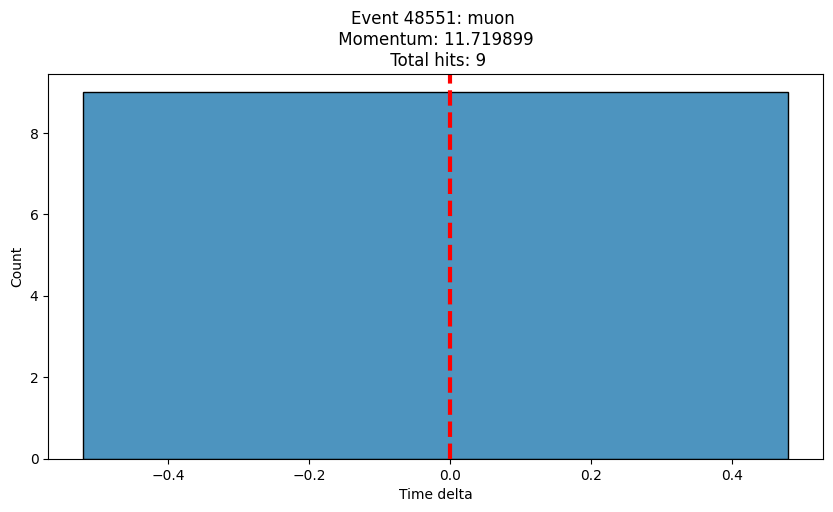

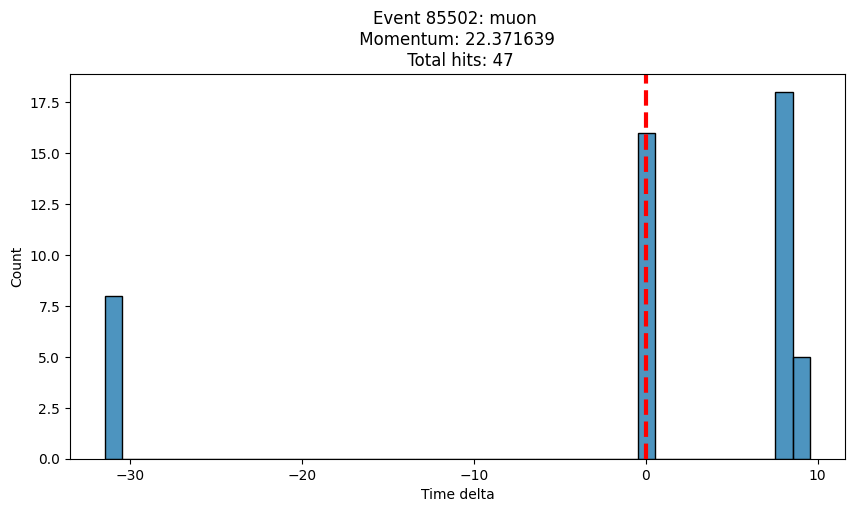

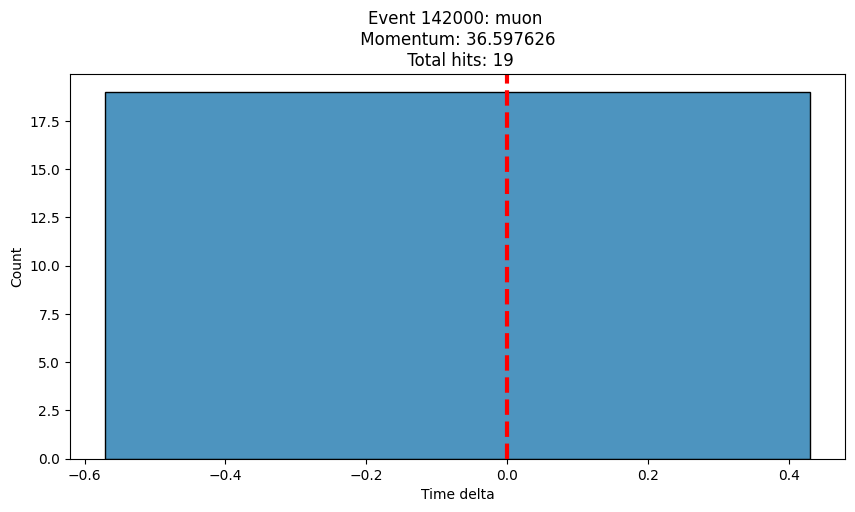

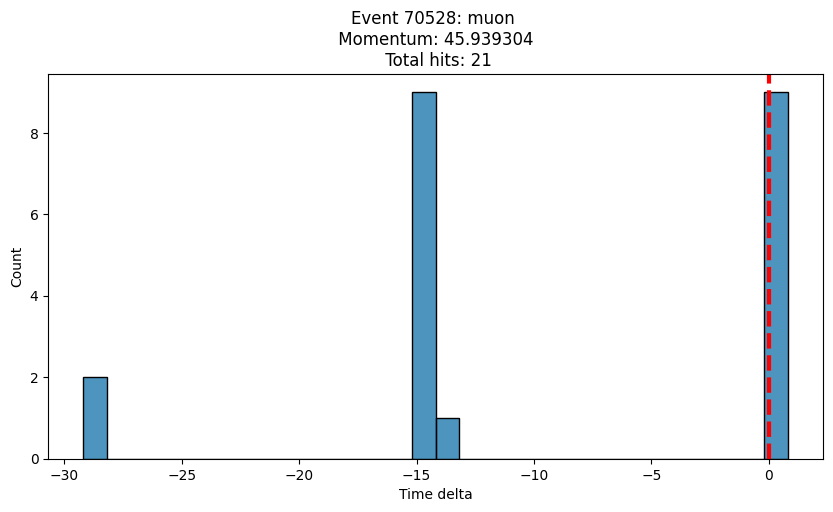

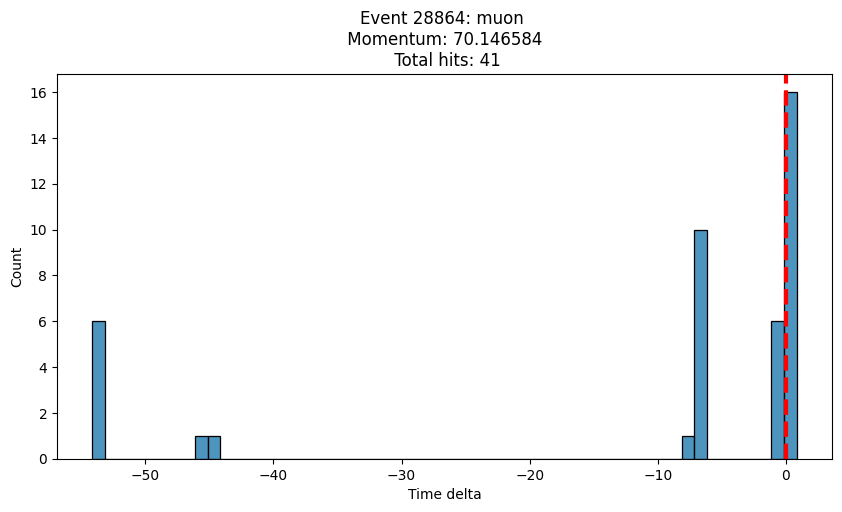

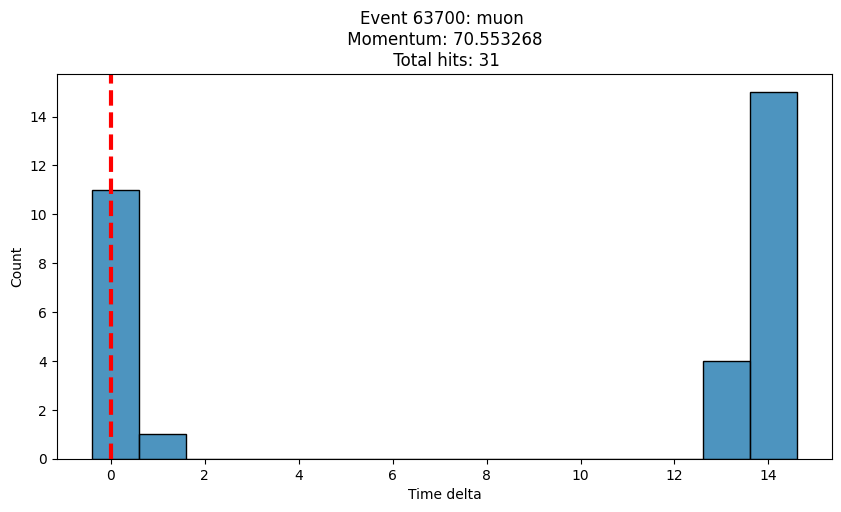

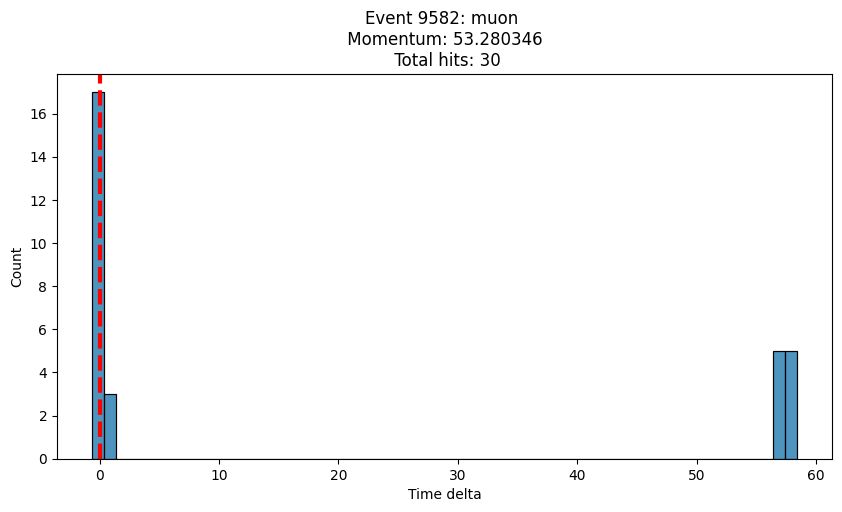

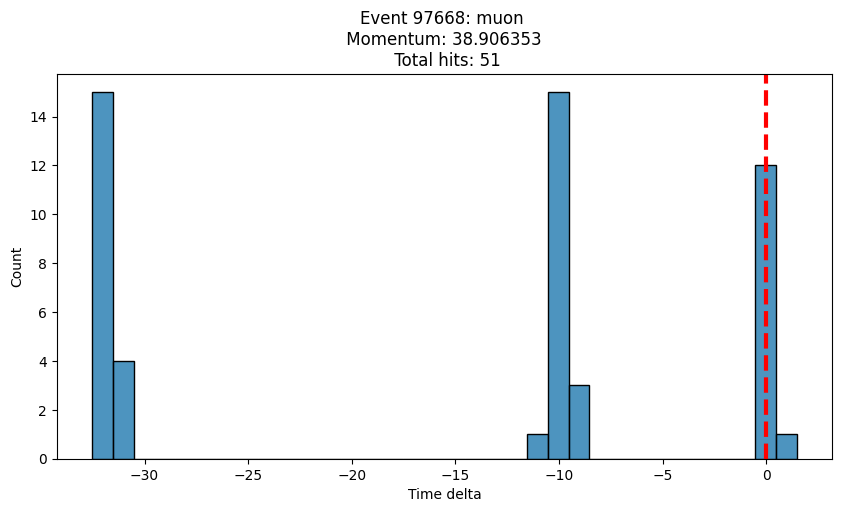

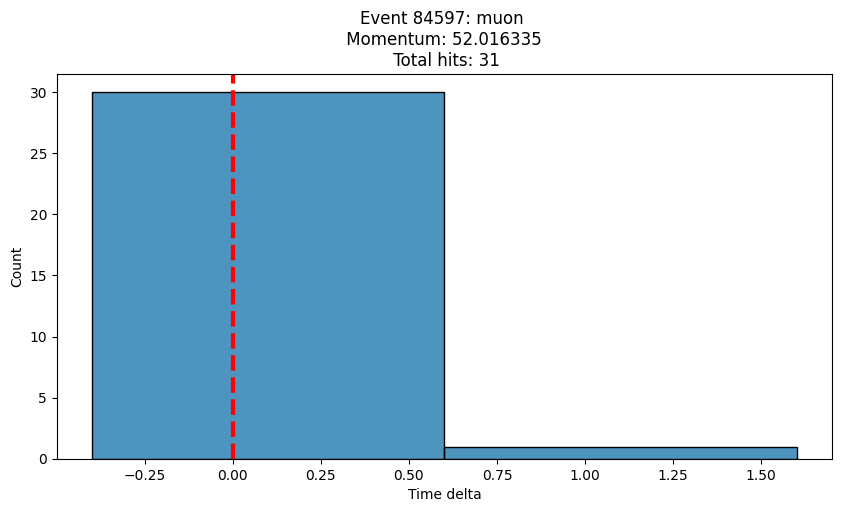

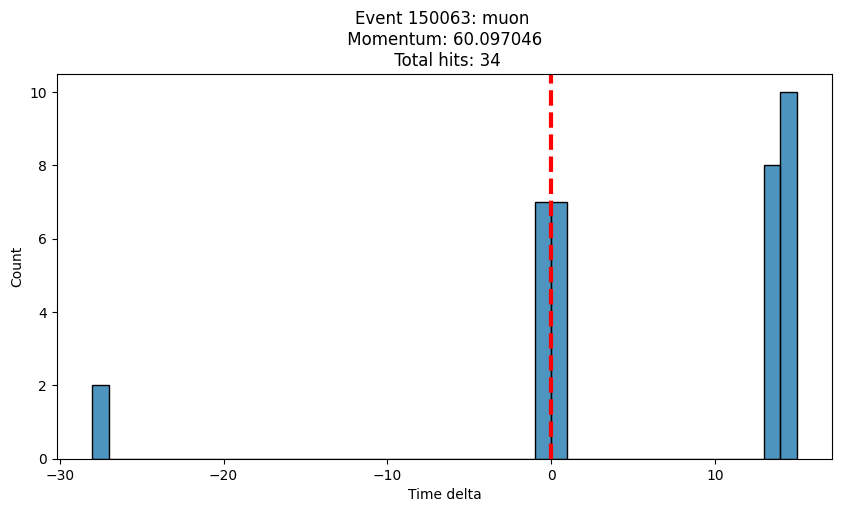

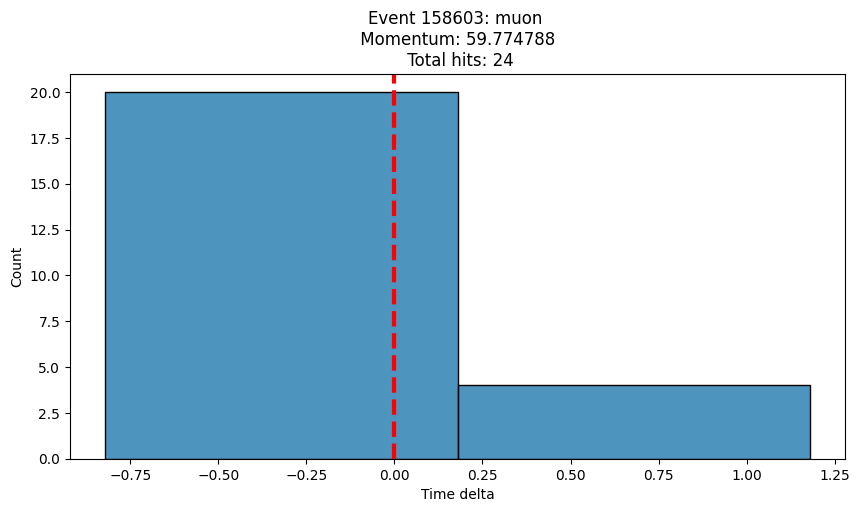

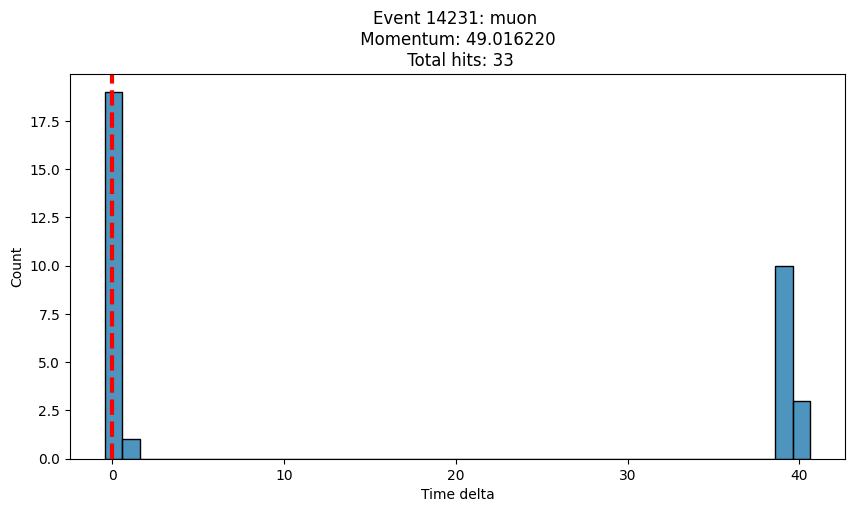

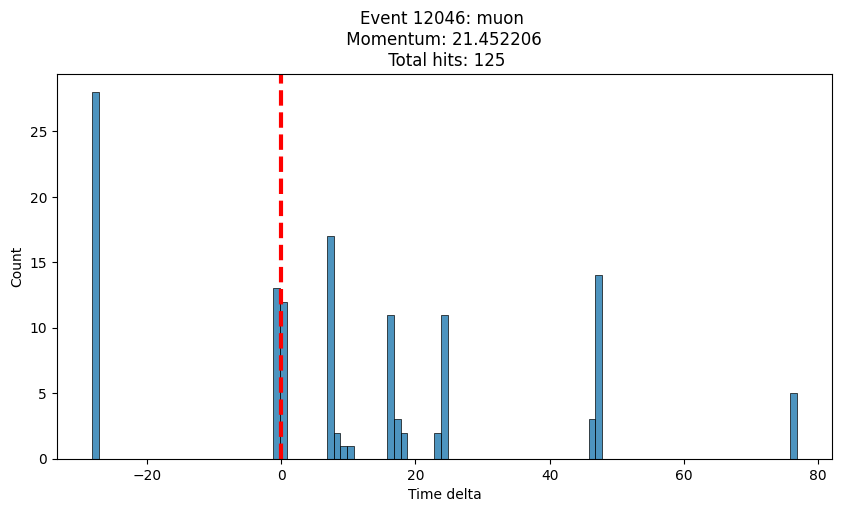

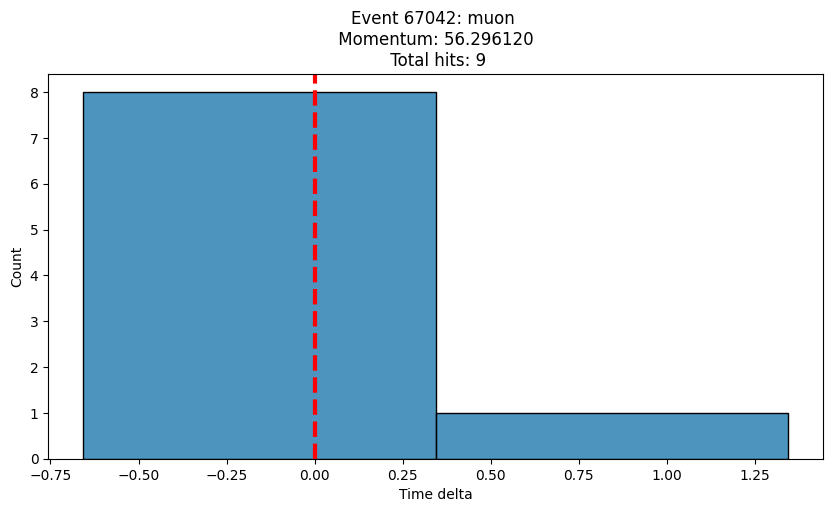

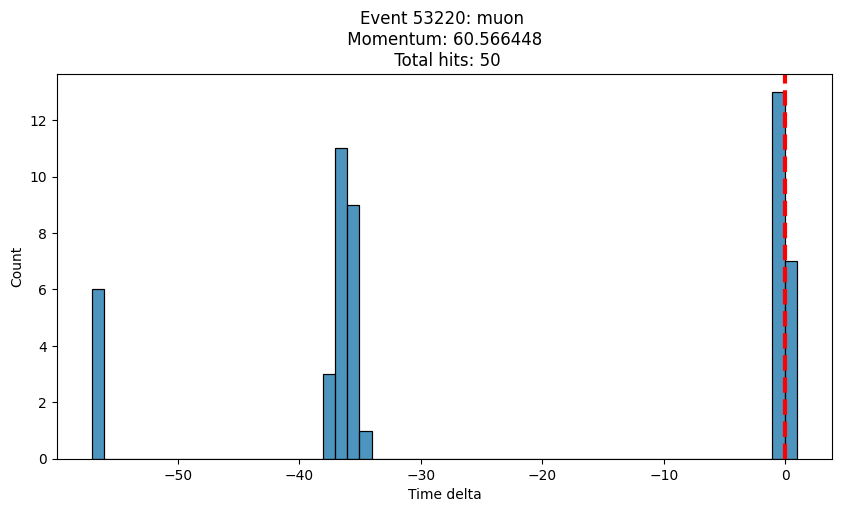

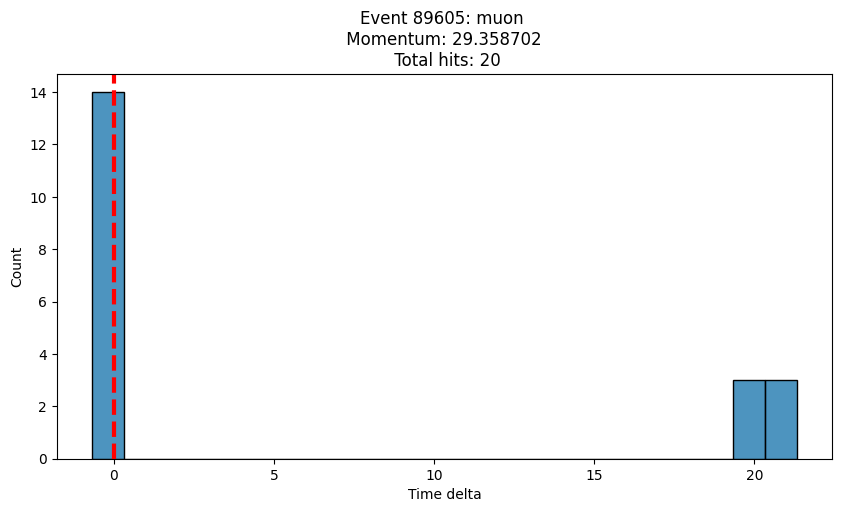

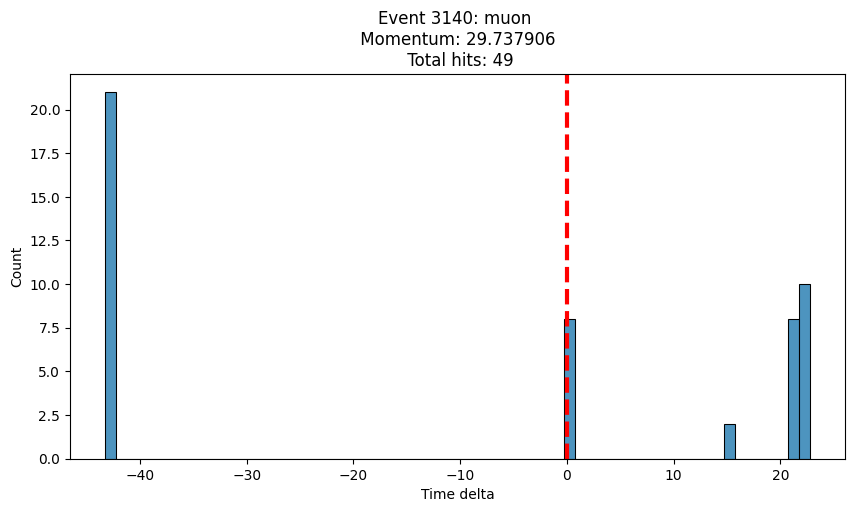

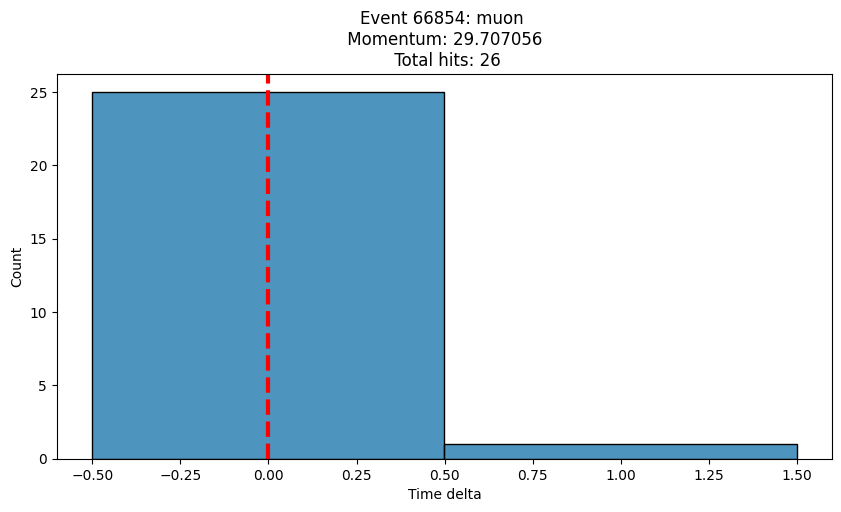

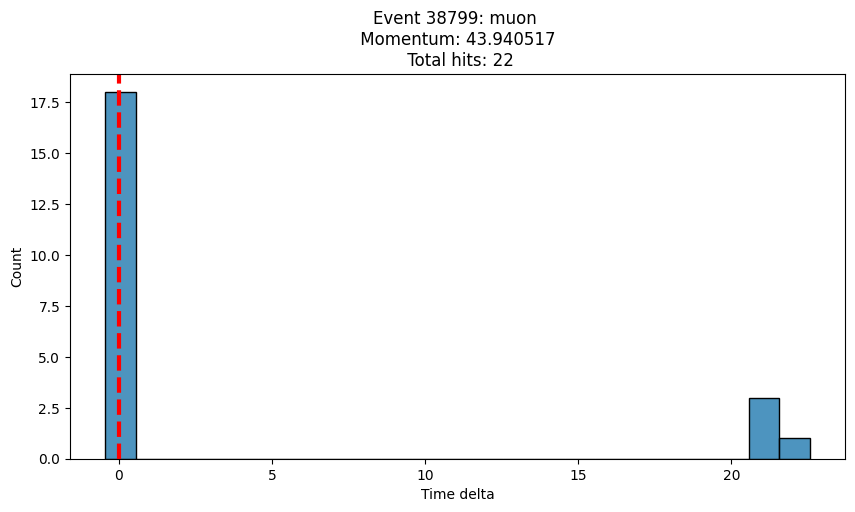

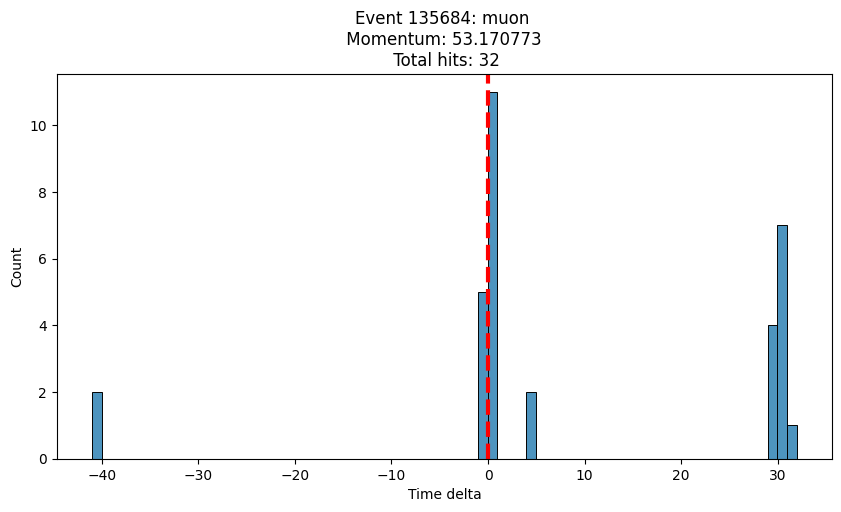

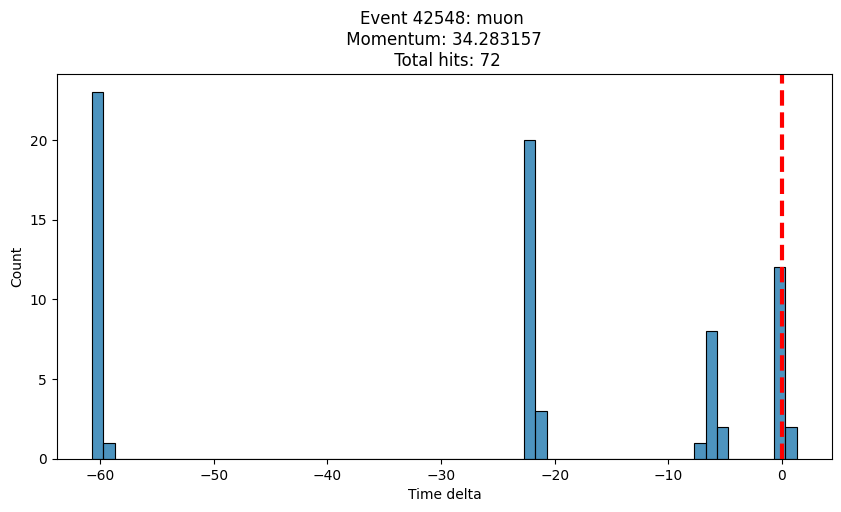

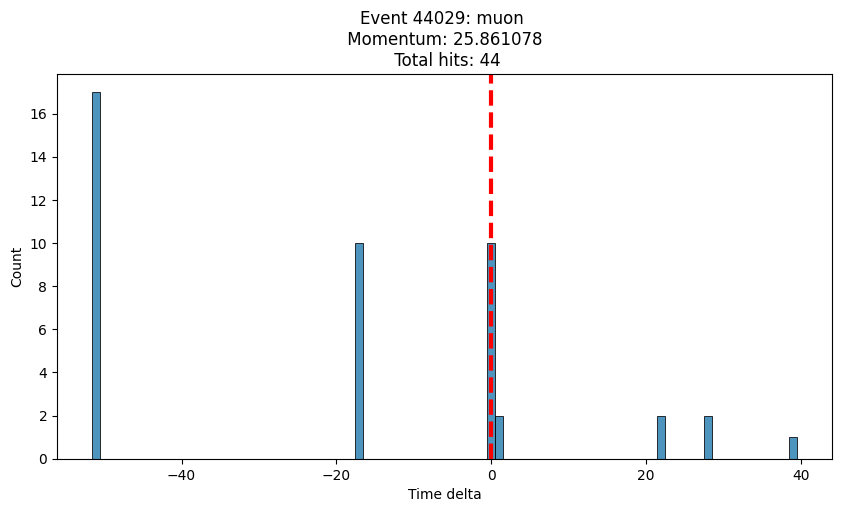

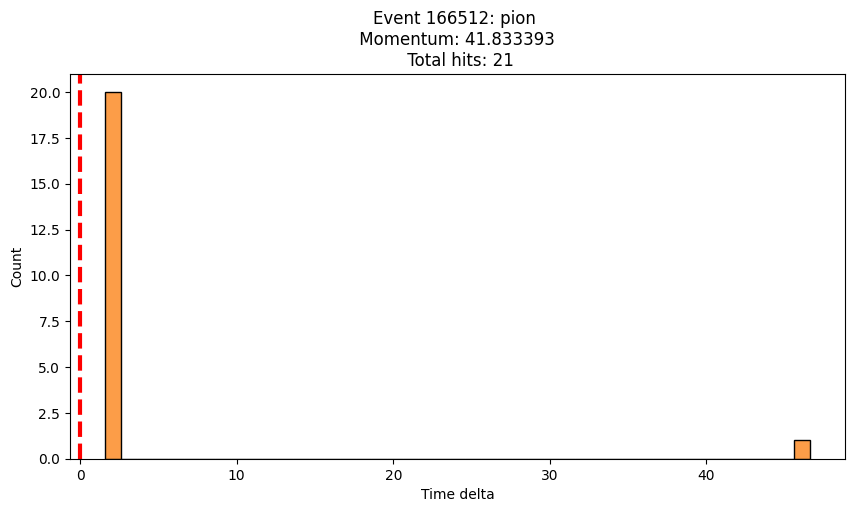

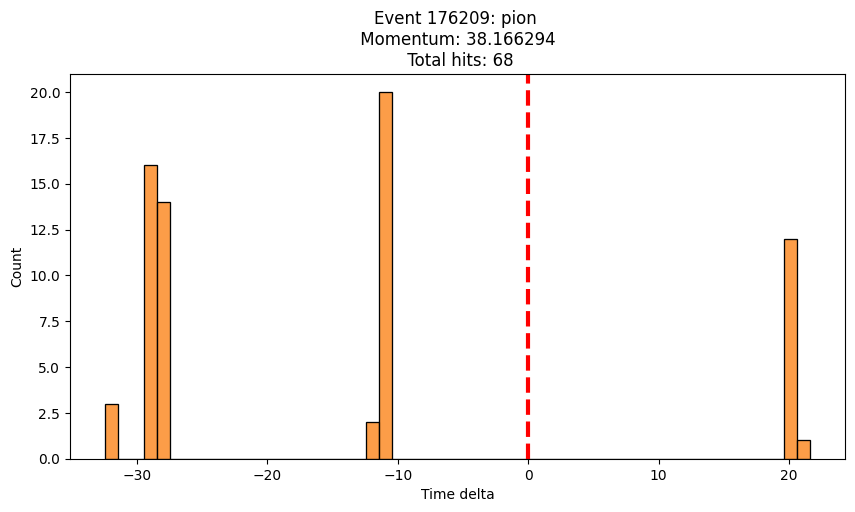

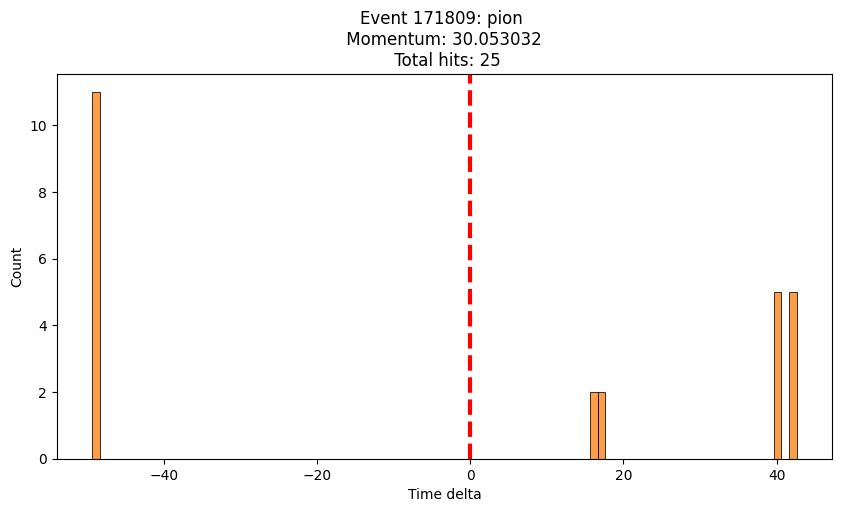

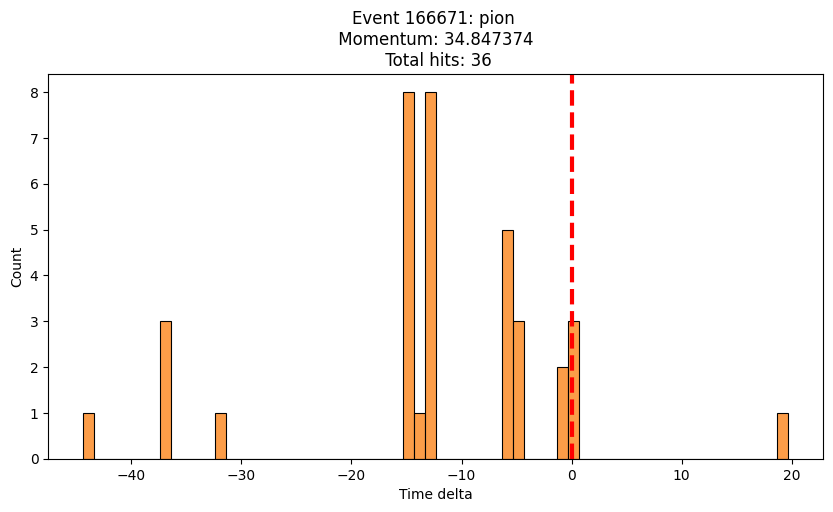

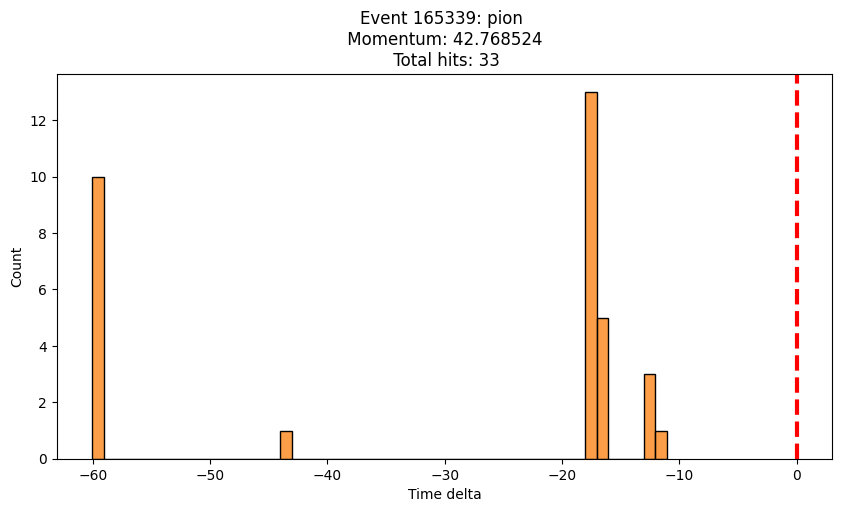

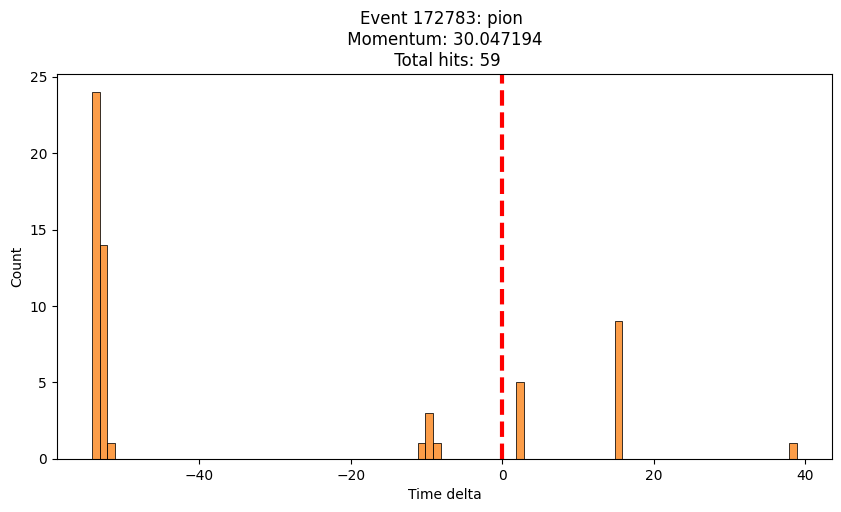

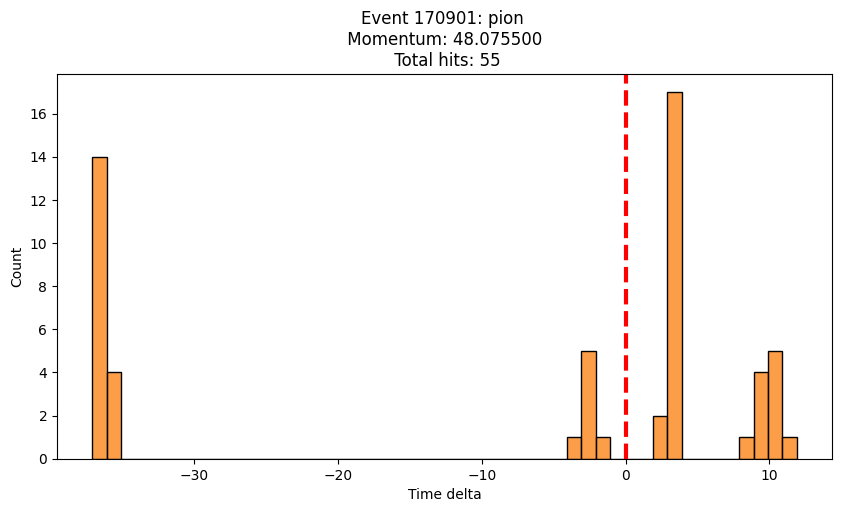

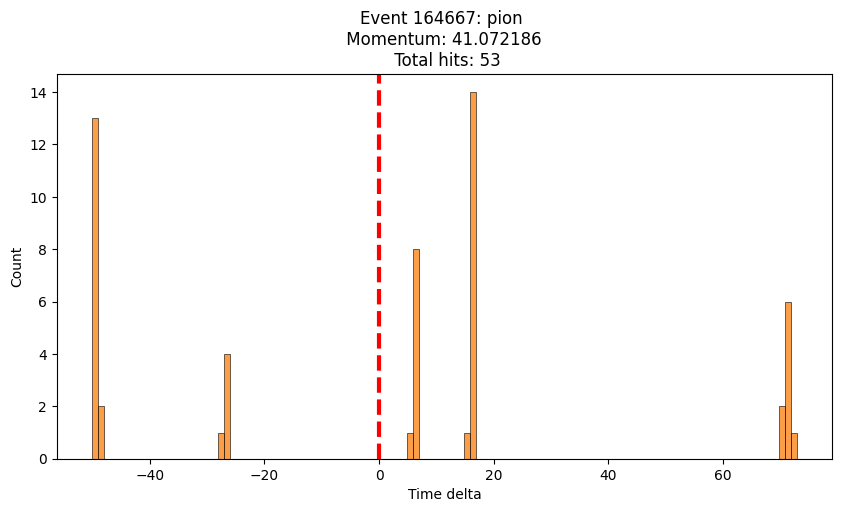

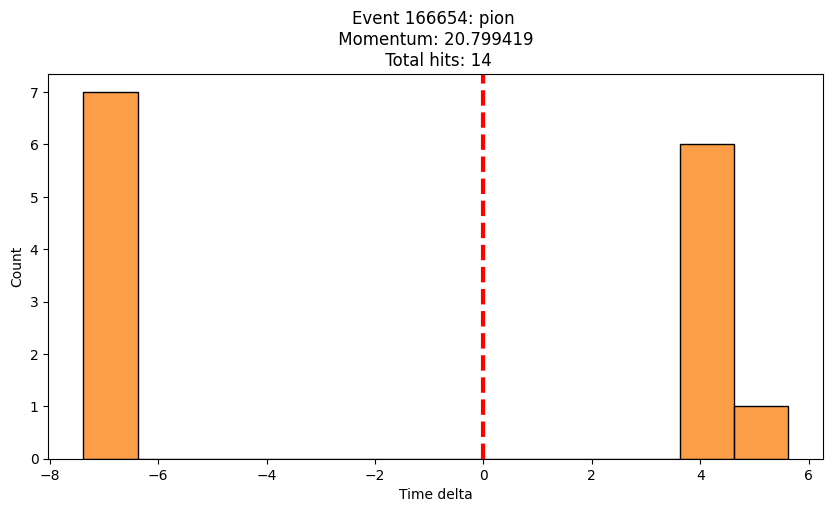

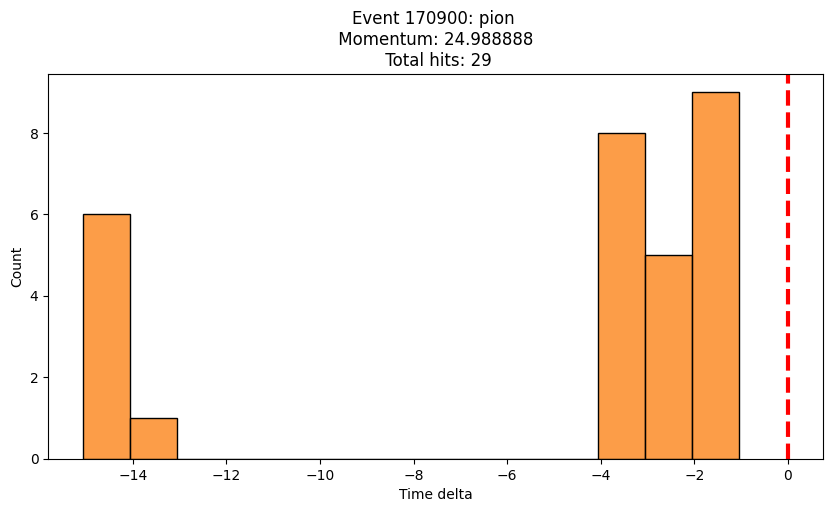

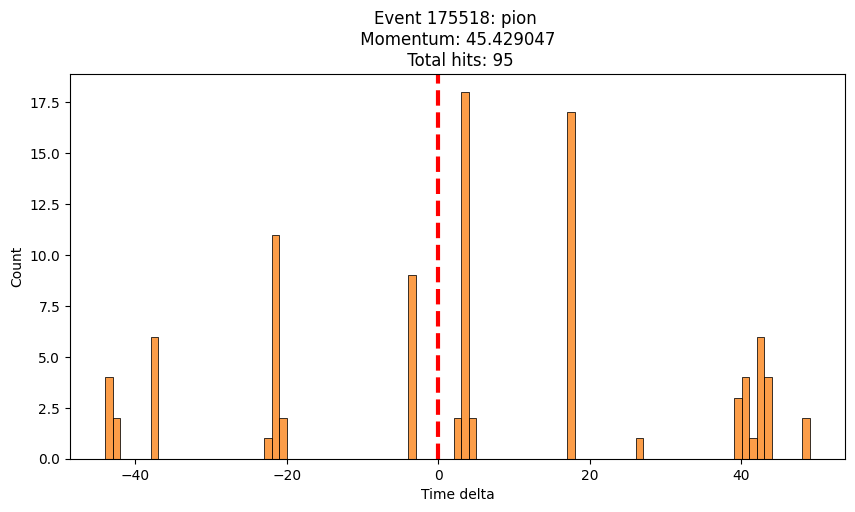

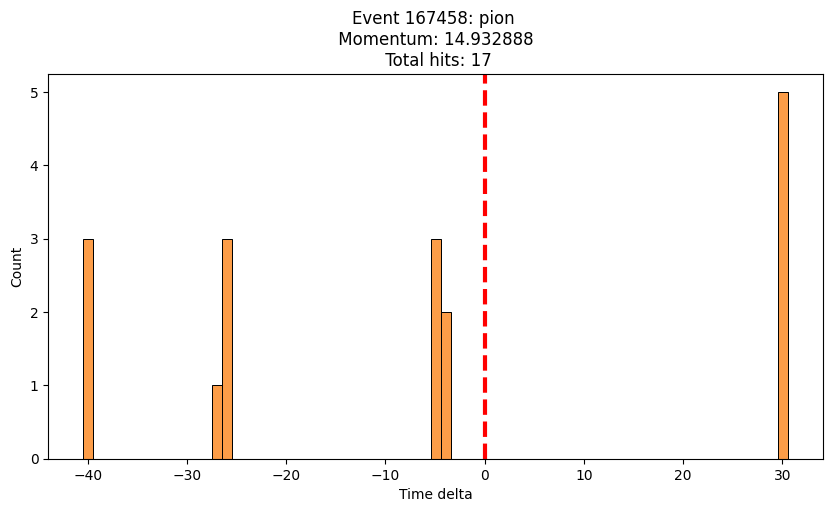

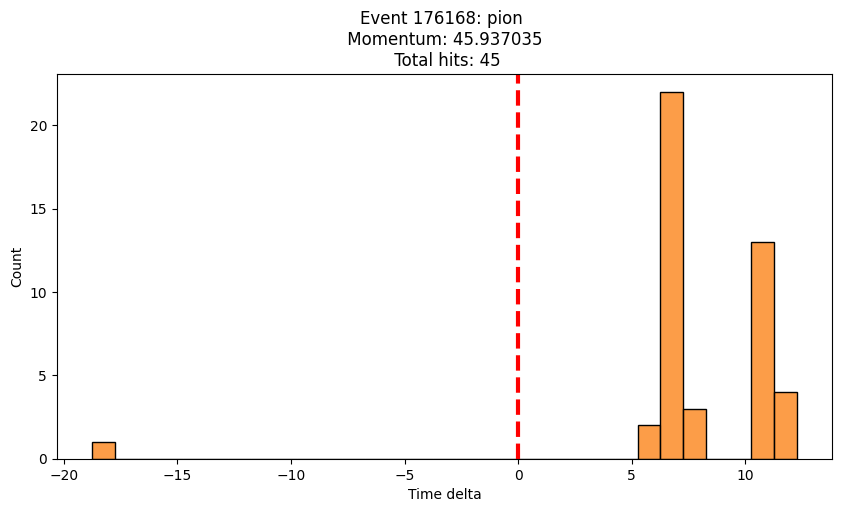

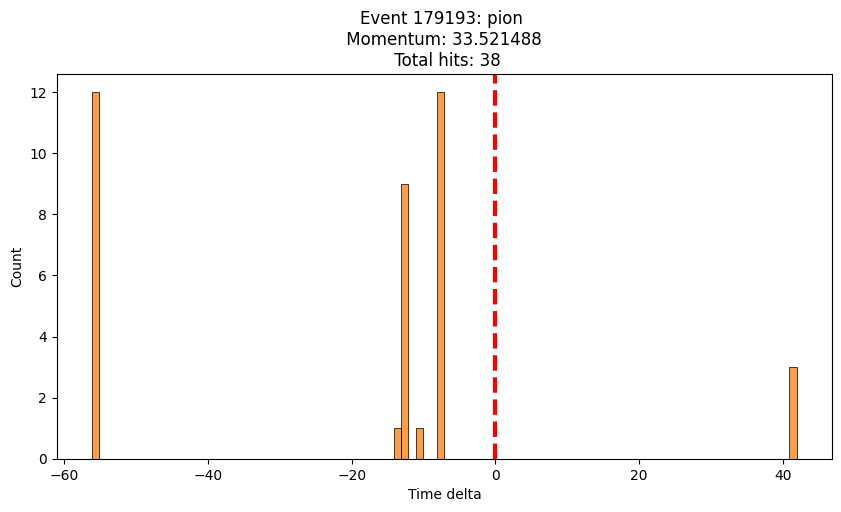

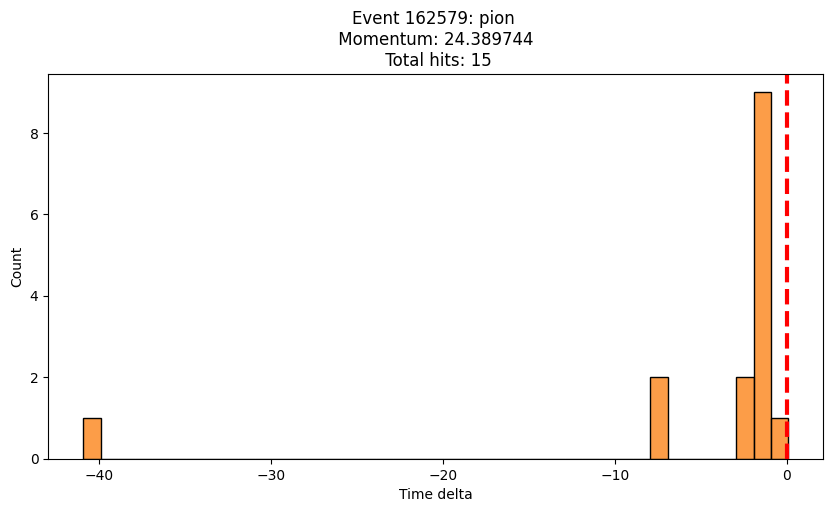

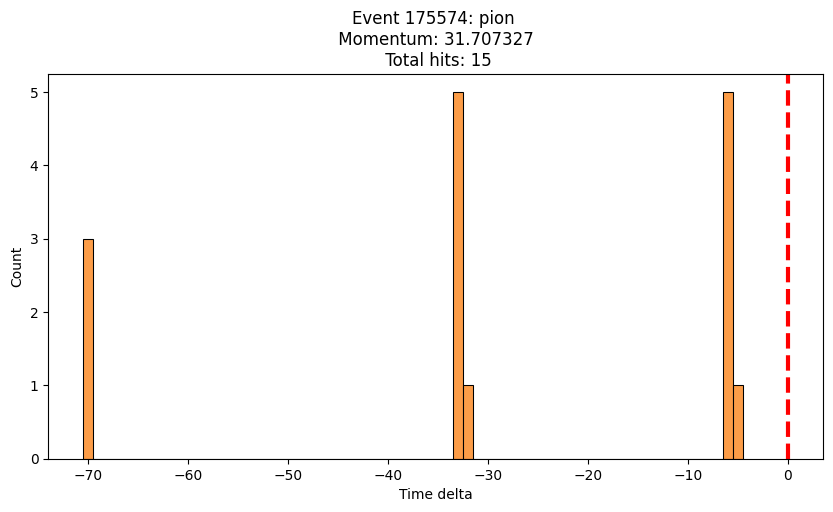

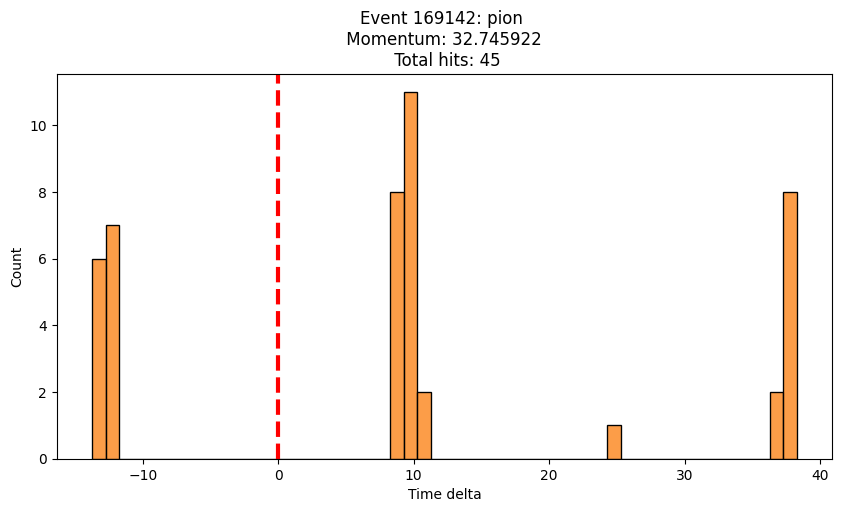

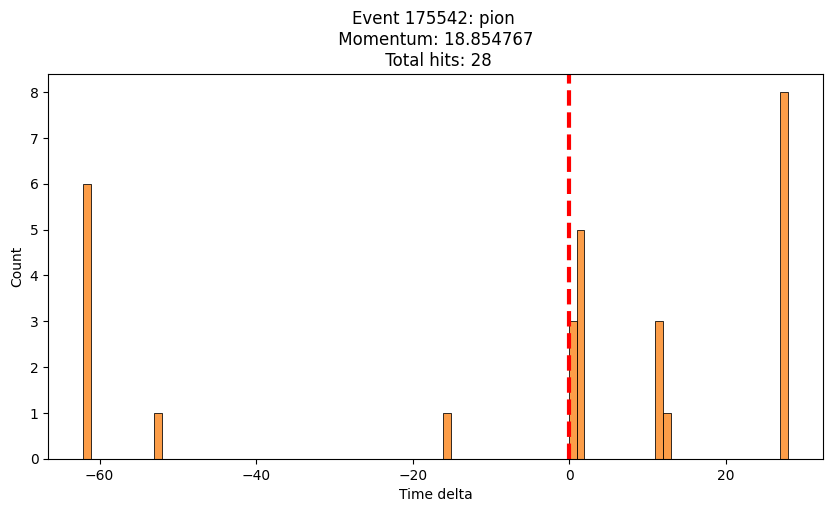

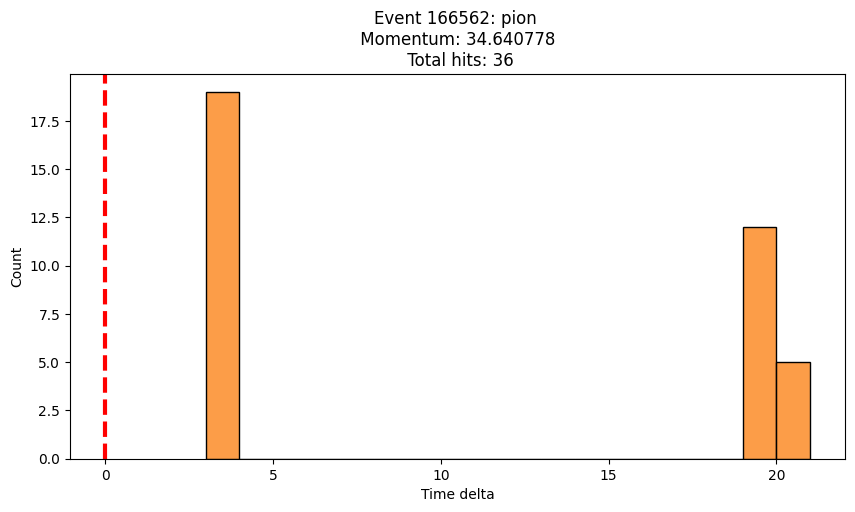

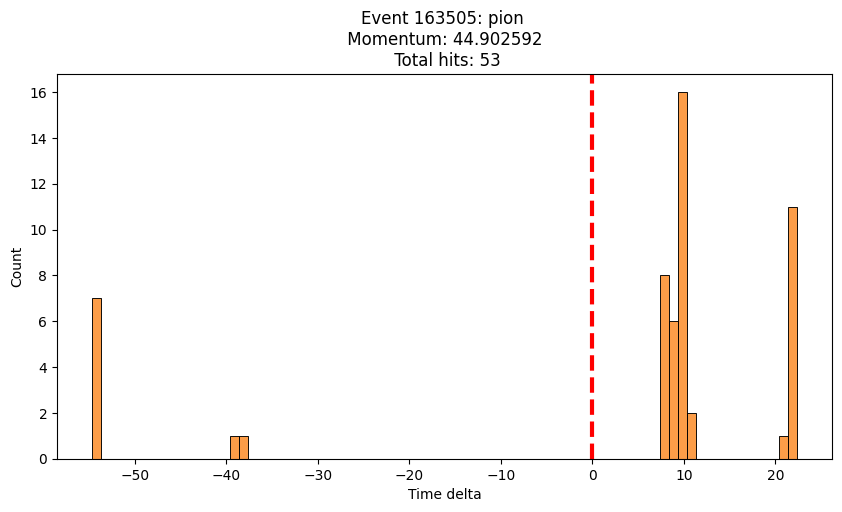

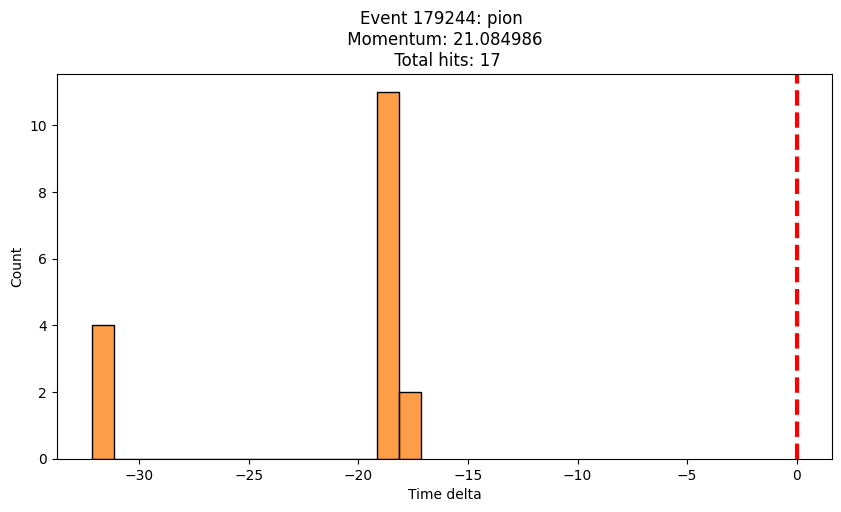

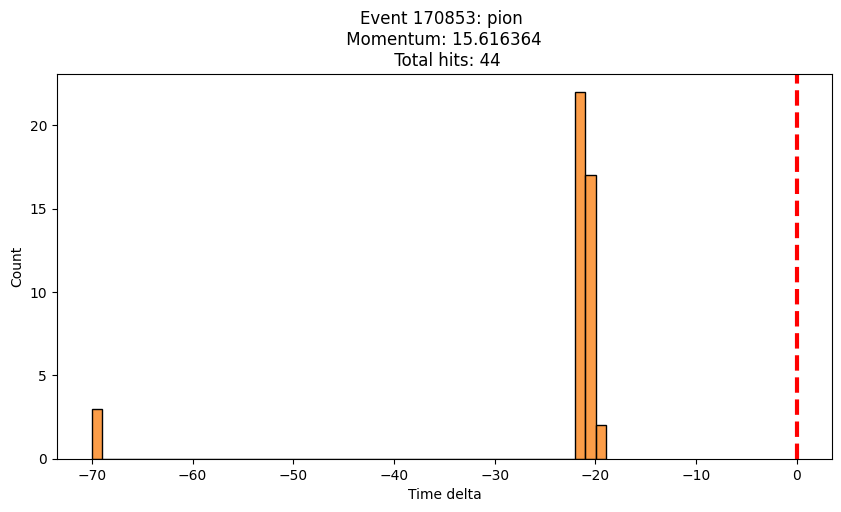

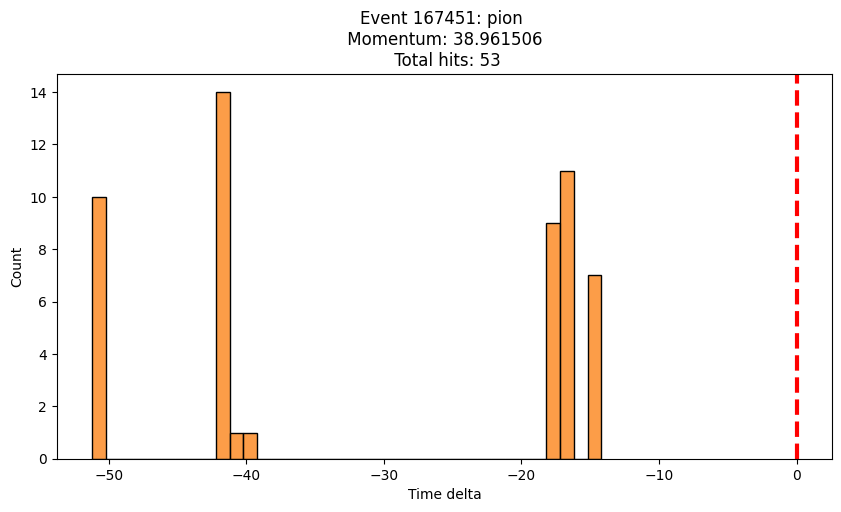

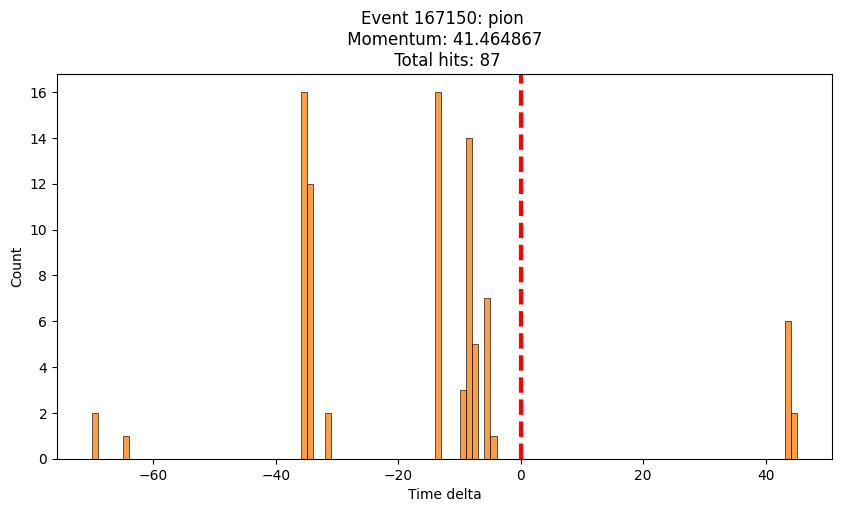

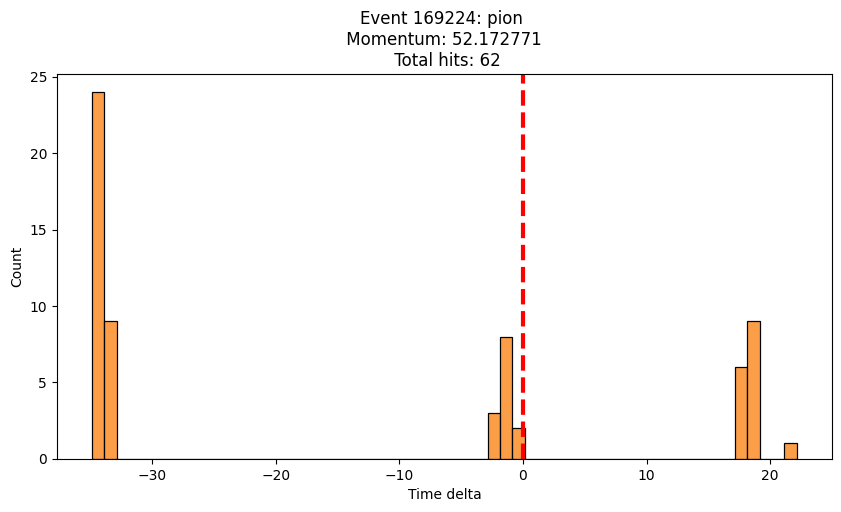

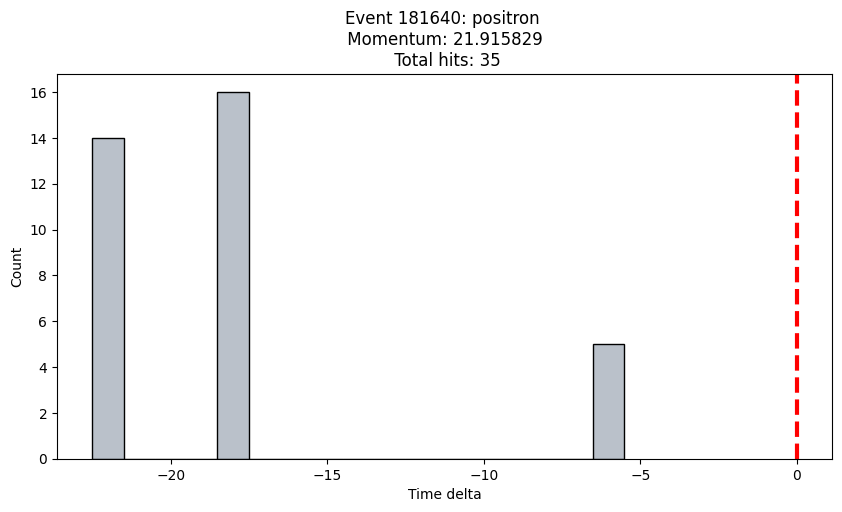

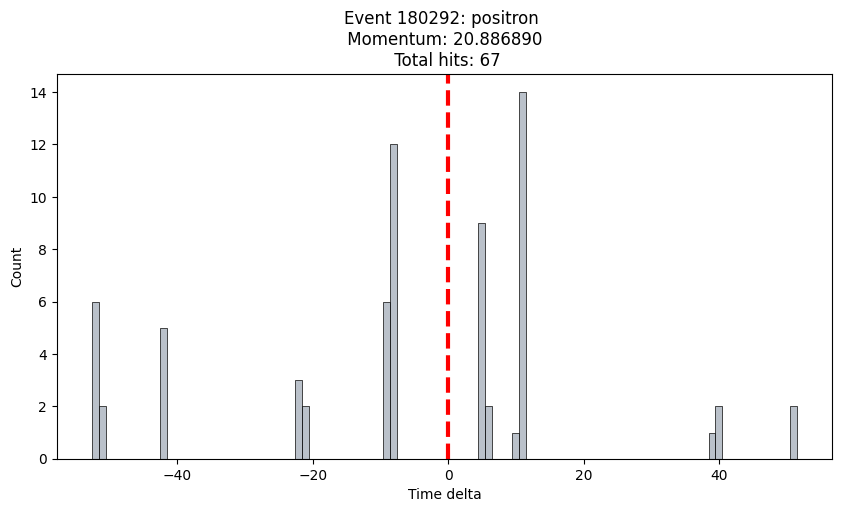

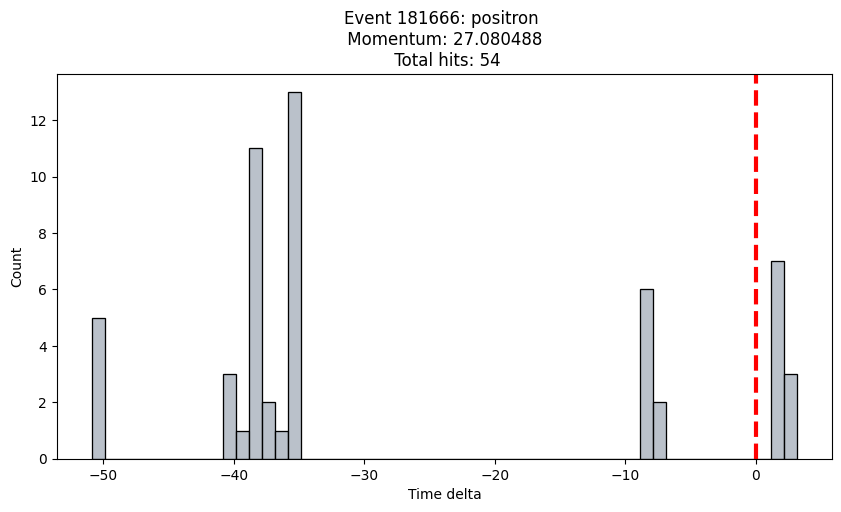

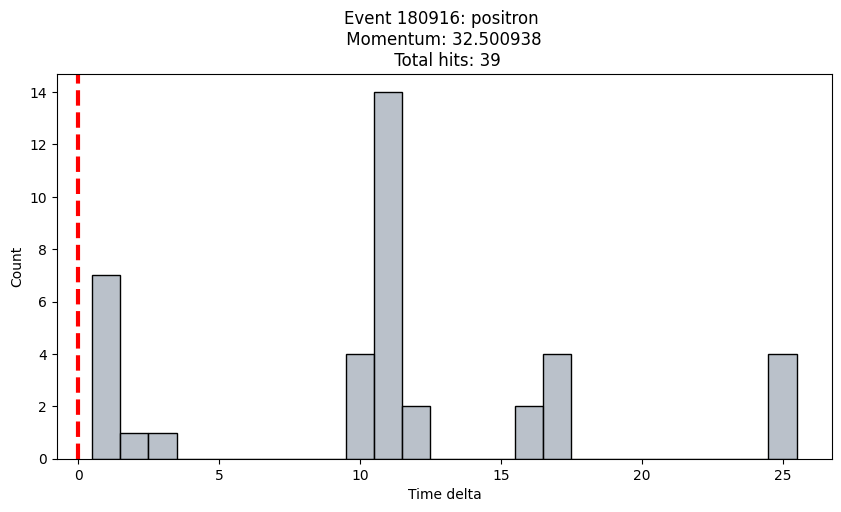

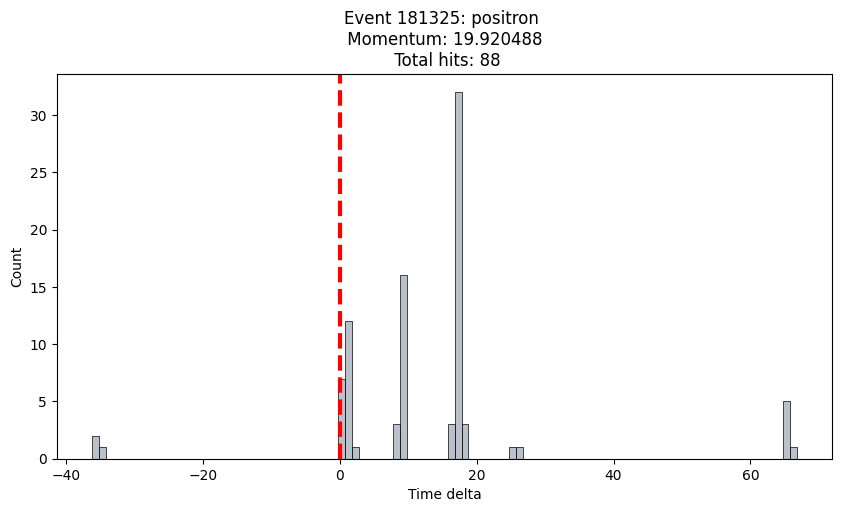

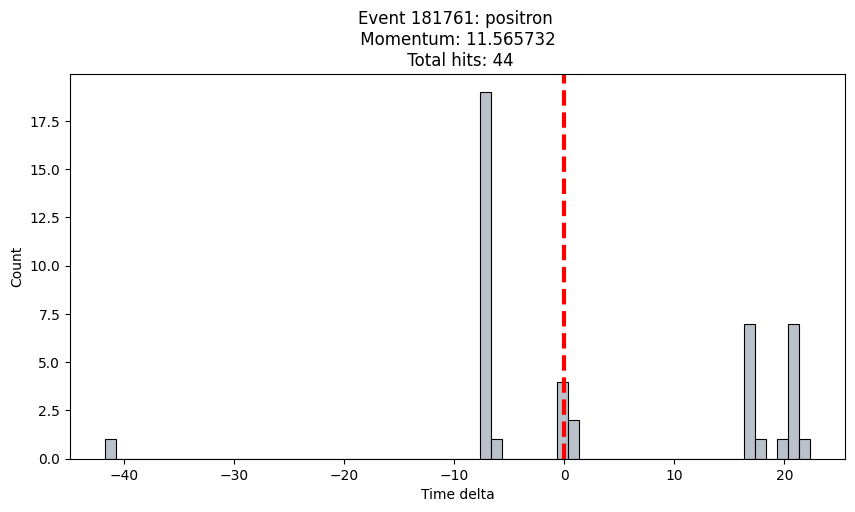

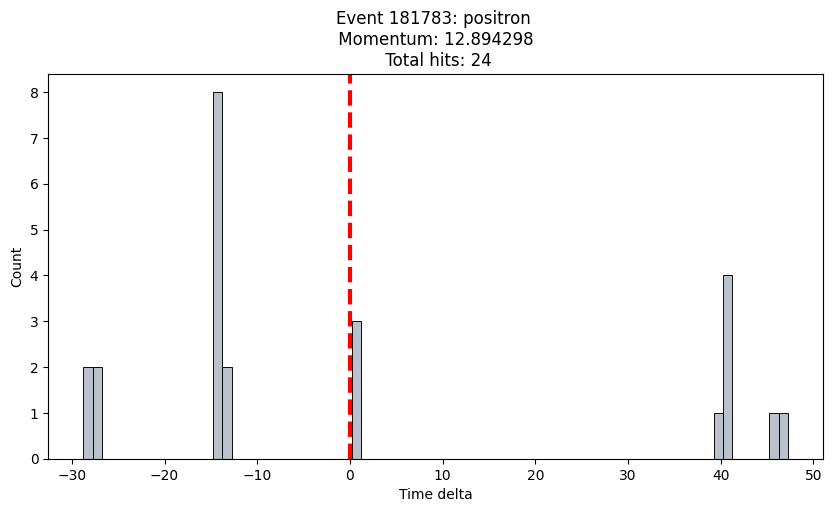

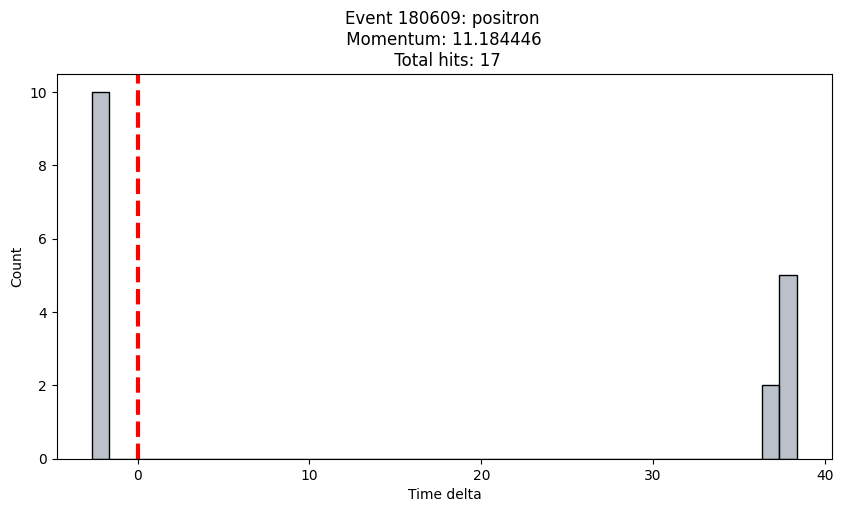

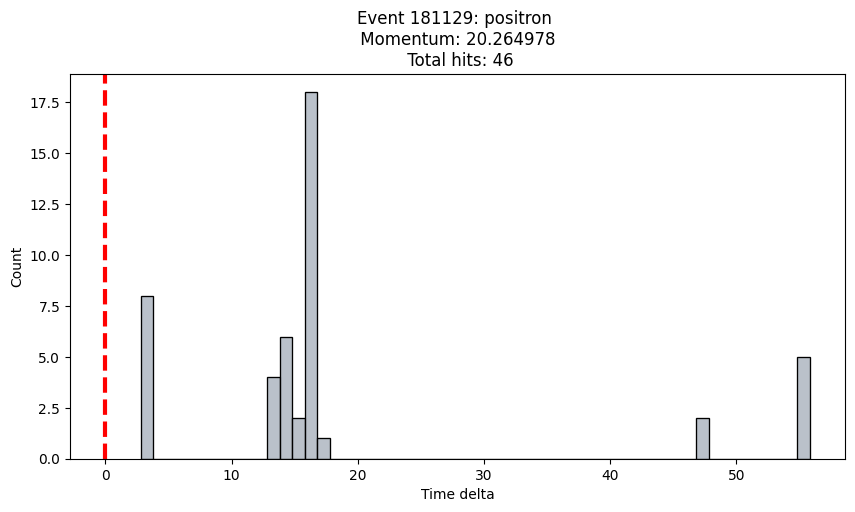

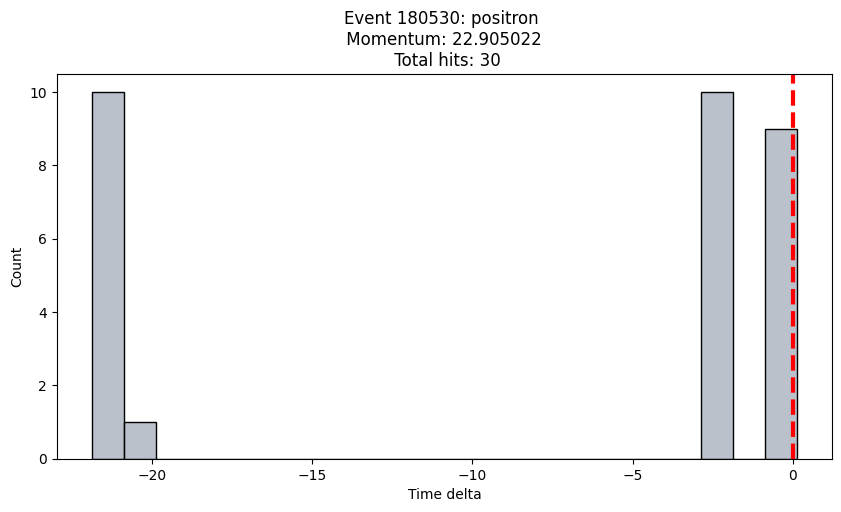

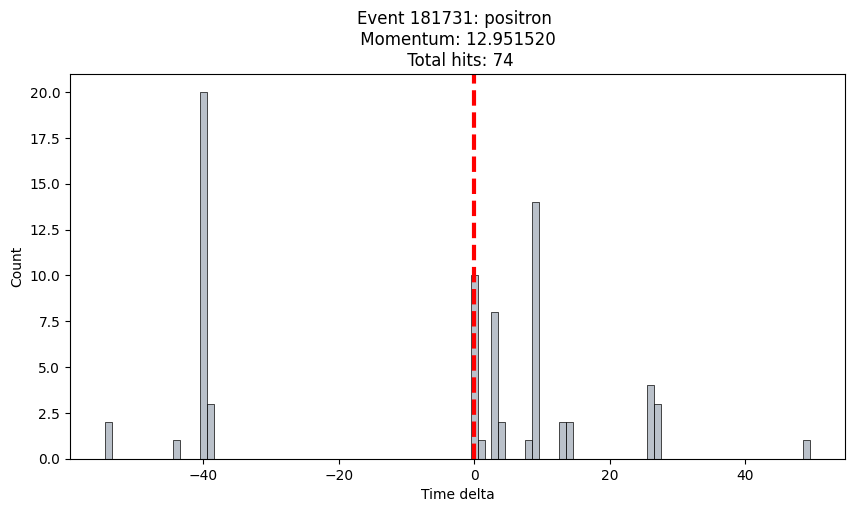

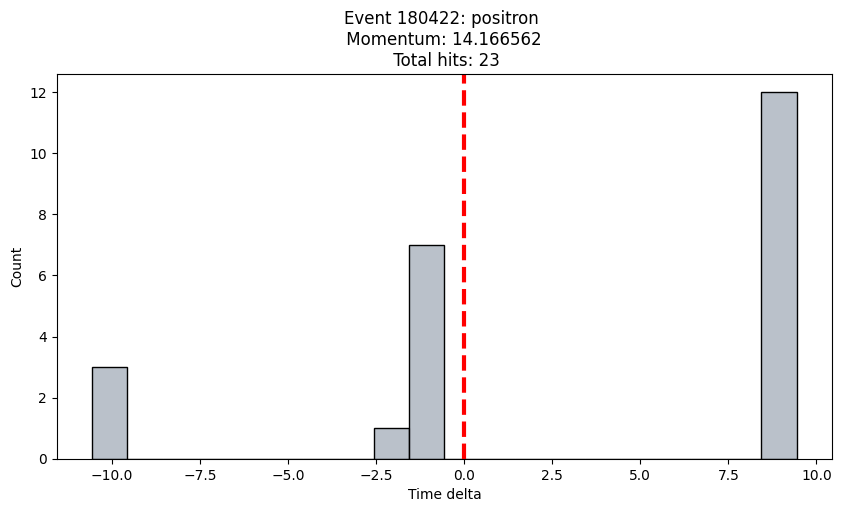

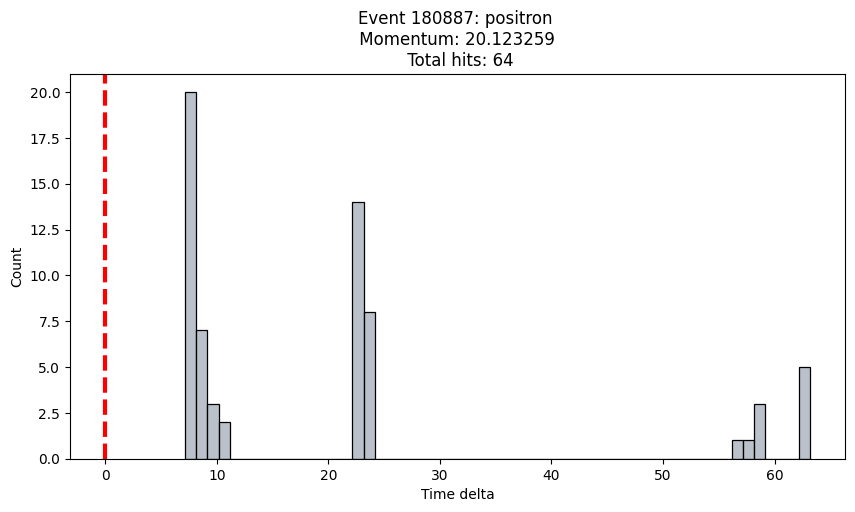

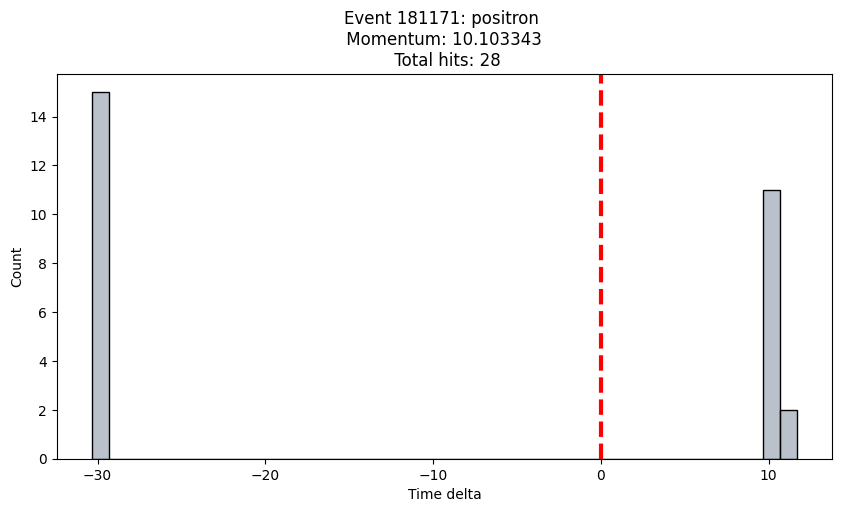

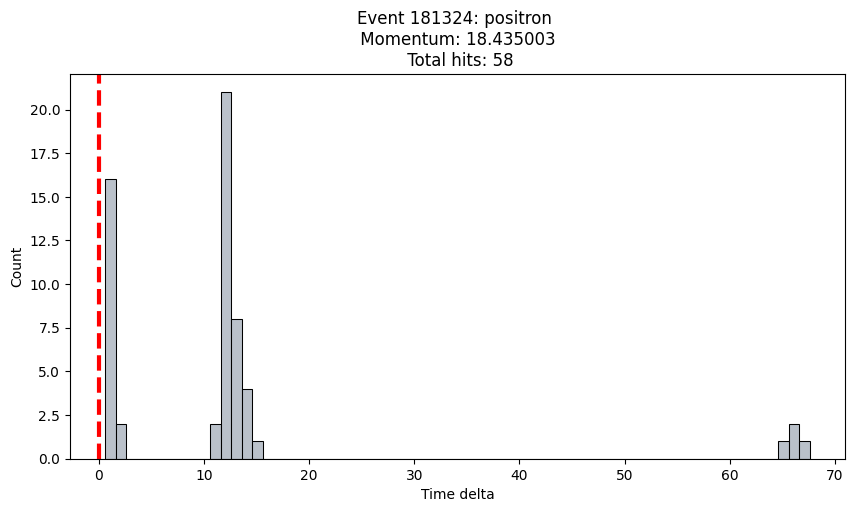

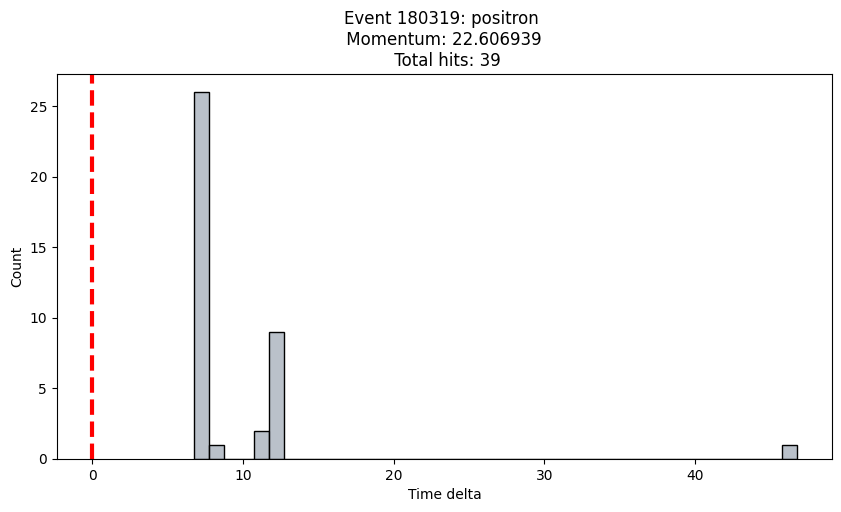

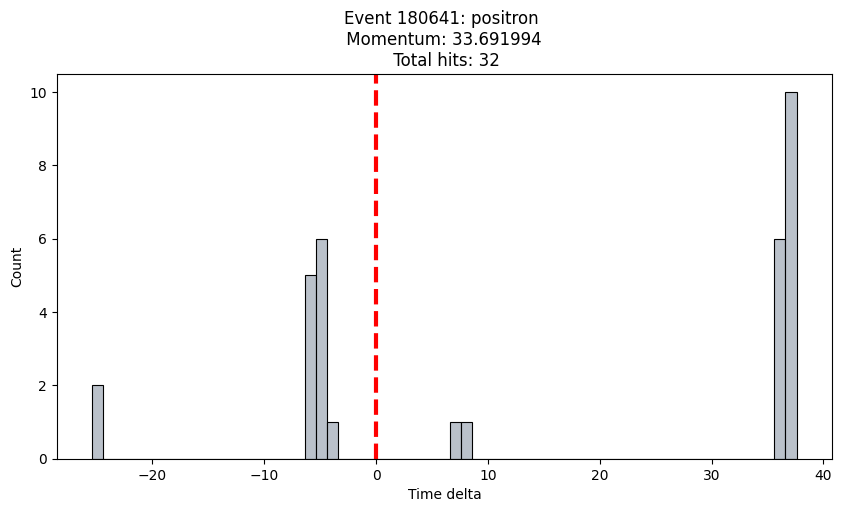

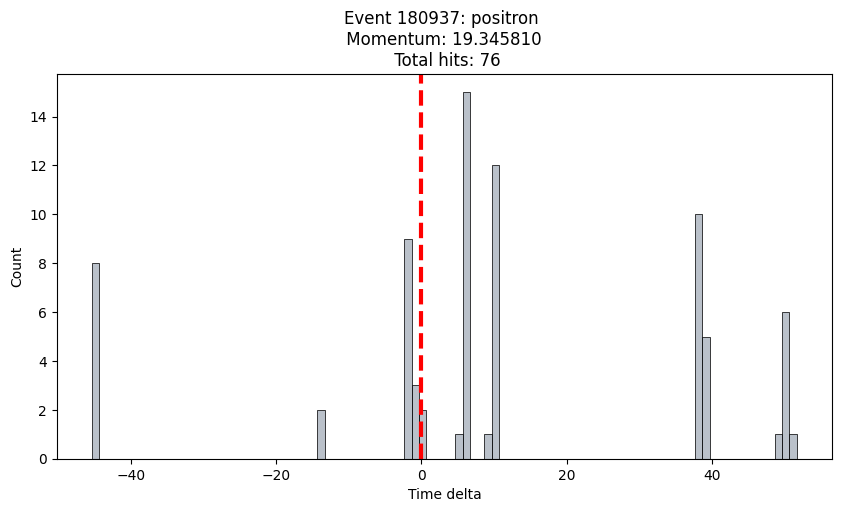

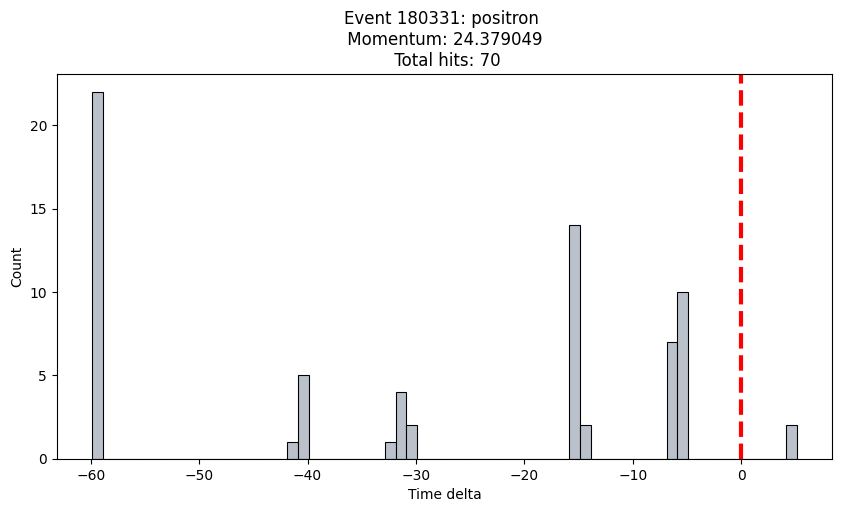

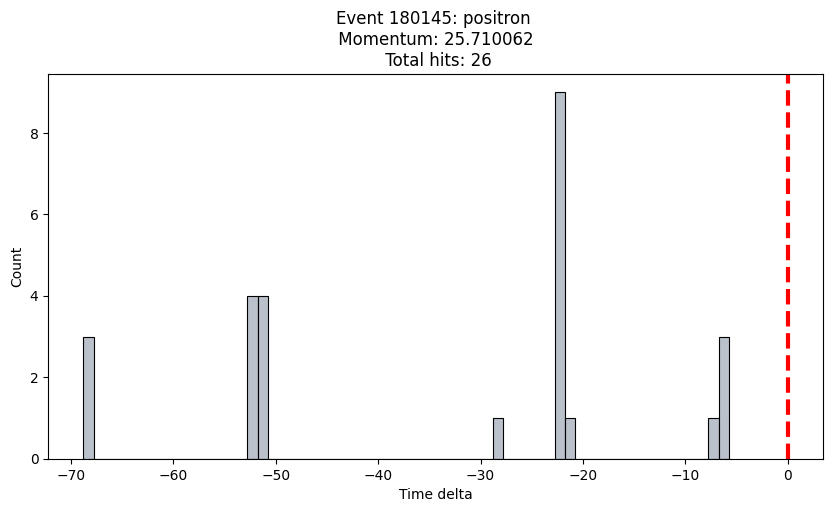

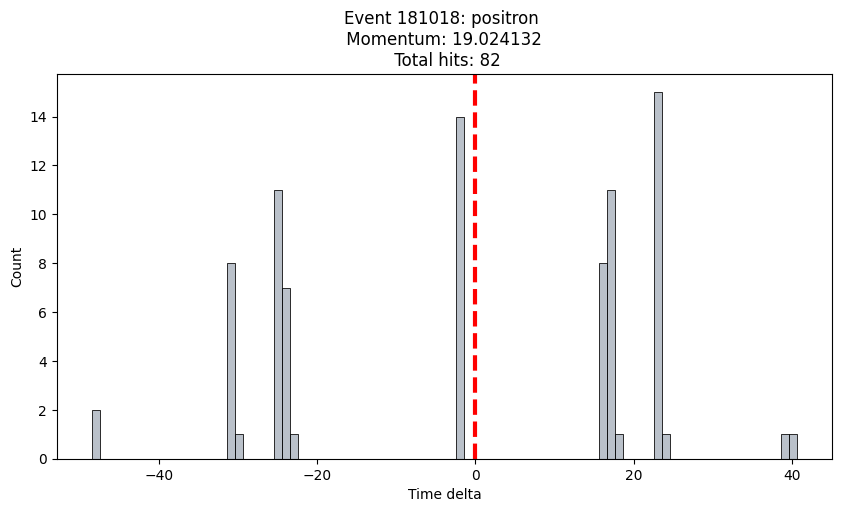

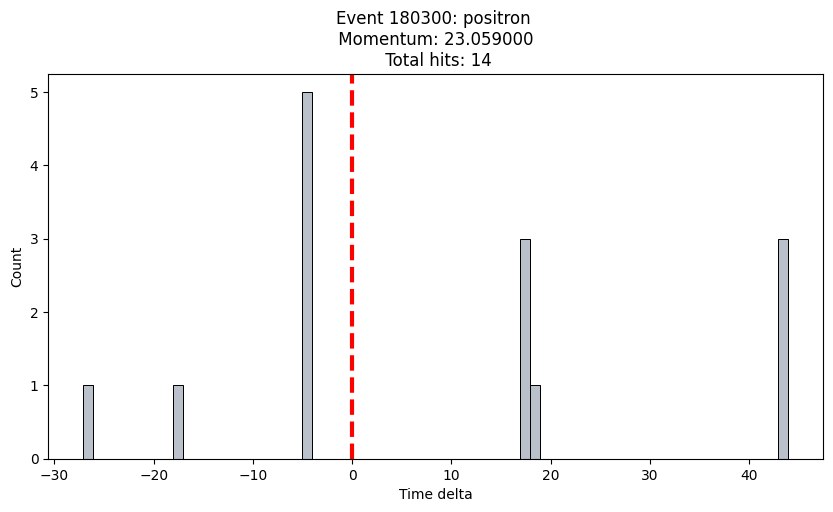

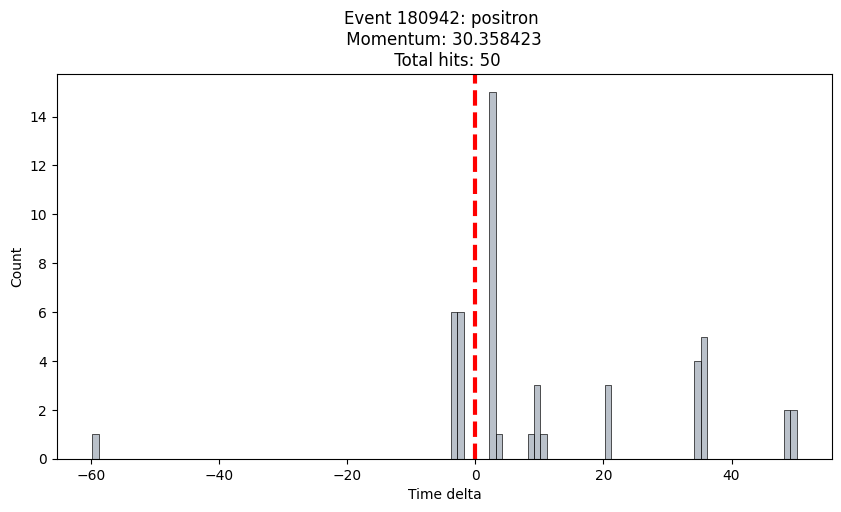

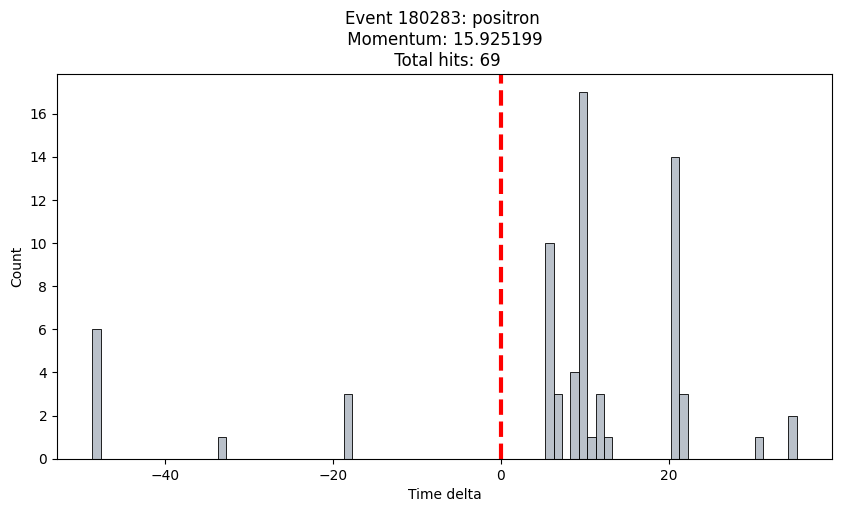

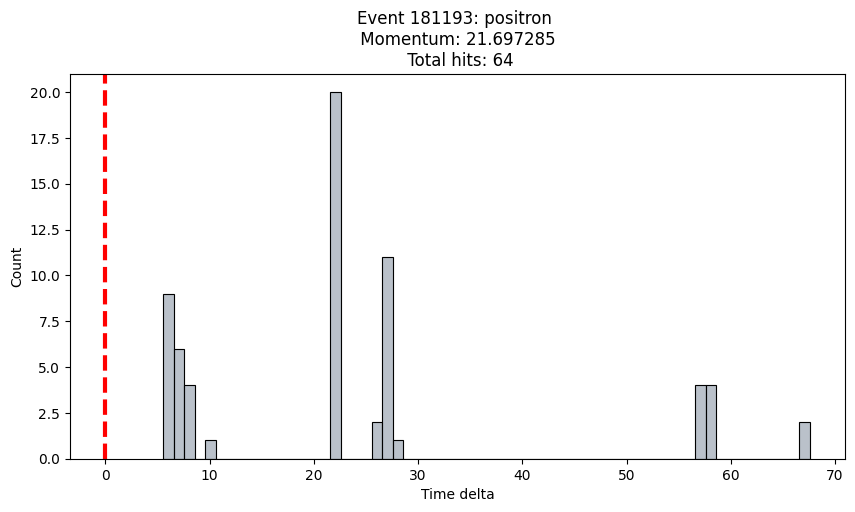

In [37]:
samples = get_class_samples(hits_df, n=25, seed=42)

for i in samples.index:
    plt.figure(figsize=(10, 5))
    hit_info = get_hit_info_df(f, samples, i)

    label = hit_info["class"].unique()[0]
    momentum = samples.loc[i]['track_momentum']
    total_hits = samples.loc[i]['total_hits']
    title = f"Event {i}: {label} \n Momentum: {momentum:2f} \n Total hits: {total_hits}"

    if label == "muon":
        color = "#1170aa"
    elif label == "pion":
        color = "#fc7d0b"
    elif label == "positron":
        color = "#a3acb9"

    sns.histplot(hit_info["chod_delta"], color=color, binwidth=1)
    plt.title(title)
    plt.xlabel("Time delta")
    plt.axvline(0, color="red", linewidth=3, linestyle="dashed")
    plt.show()

## Ring plots

<div class="alert alert-warning">
Something is up with the alignment of the ring centre...
</div>

In [64]:
hit_info

x           y  mirror  x_realigned  y_realigned   hit_time  chod_time  \
0   261.0   62.349998     0.0        114.2    42.549998  12.033796   4.451726   
1   225.0  124.709999     0.0         78.2   104.909999  11.958707   4.451726   
2   189.0  -62.349998     0.0         42.2   -82.149998  11.741527   4.451726   
3   234.0  -77.940002     0.0         87.2   -97.740002  11.885616   4.451726   
4    36.0 -109.120003     0.0       -110.8  -128.920003  12.008956   4.451726   
..    ...         ...     ...          ...          ...        ...        ...   
59  225.0  124.709999     0.0         78.2   104.909999  71.612709   4.451726   
60  -36.0   15.590000     0.0       -182.8    -4.210000  31.512812   4.451726   
61  -27.0   62.349998     0.0       -173.8    42.549998  30.694592   4.451726   
62   81.0  124.709999     0.0        -65.8   104.909999  31.055986   4.451726   
63  252.0   15.590000     0.0        105.2    -4.210000  31.200451   4.451726   

    chod_delta     class   event  
0     7.582070  positron  181193  
1     7.506980  positron  181193  
2     7.289800  positron  181193  
3     7.433890  positron  181193  
4     7.557230  positron  181193  
..         ...       ...     ...  
59   67.160980  positron  181193  
60   27.061085  positron  181193  
61   26.242865  positron  181193  
62   26.604259  positron  181193  
63   26.748724  positron  181193  

[64 rows x 10 columns]

In [88]:
def realign_x_hits(x, mirror):
    if mirror == 0:
        return x - 146.8
    else:
        return x + 196.7
    
def realign_y_hits(y, mirror):
    if mirror == 0:
        return y - 19.8
    else:
        return y - 9.5

In [83]:
def plot_rings(samples):
    for i in samples.index:
        momentum = samples.loc[i]["track_momentum"]
        radius = samples.loc[i]["ring_radius"]
        x, y = samples.loc[i]["ring_centre_pos_x"], samples.loc[i]["ring_centre_pos_y"]
        hit_info = get_hit_info_df(f, samples, i)
        label = hit_info["class"].unique()[0]
        mirror = hit_info["mirror"].unique()[0]
        
        if mirror == 0:
            marker = "^"
#             x -= -146.8
#             y -= 19.8
        else:
            marker = "s"
#             x += 196.7
#             y -= 9.5
        
        title = f"""
        Event {i}: {label}
        Momentum: {momentum:2f}
        Centre: ({x:2f}, {y:2f})
        Radius: {radius:2f}
        Mirror: {mirror}"""

        fig = plt.figure(figsize=(10, 10))
        ax = fig.subplots()
        ax.set_aspect('equal')
#         ax.set_xlim(-350,350) # mm
#         ax.set_ylim(-350,350) # mm
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_title(title)

#         draw_pmt_pos(ax, position_map)
        plt.scatter(hit_info['x_realigned'], hit_info['y_realigned'], c=np.power(hit_info["chod_delta"], 2), cmap="cividis", marker=marker)
        cbar = plt.colorbar(shrink=0.8)
        cbar.set_label("Squared Time Delta", fontsize=12)
        plt.clim(0, 50)
        ax.add_artist(plt.Circle((x, y), radius, fill=False,color="red"))
        plt.show()

# Note: The colour bar is the squared (hit time - CHOD time)

Tried both realignments, did not work

# 5 Ring Plots for Each Particle for Momentum bin '0-9'

<div class="alert alert-warning">
Several of these rings have a wonky centre of (999999, 999999)?
</div>

In [89]:
hit_info

x           y  mirror  x_realigned  y_realigned   hit_time  chod_time  \
0   261.0   62.349998     0.0        114.2    42.549998  12.033796   4.451726   
1   225.0  124.709999     0.0         78.2   104.909999  11.958707   4.451726   
2   189.0  -62.349998     0.0         42.2   -82.149998  11.741527   4.451726   
3   234.0  -77.940002     0.0         87.2   -97.740002  11.885616   4.451726   
4    36.0 -109.120003     0.0       -110.8  -128.920003  12.008956   4.451726   
..    ...         ...     ...          ...          ...        ...        ...   
59  225.0  124.709999     0.0         78.2   104.909999  71.612709   4.451726   
60  -36.0   15.590000     0.0       -182.8    -4.210000  31.512812   4.451726   
61  -27.0   62.349998     0.0       -173.8    42.549998  30.694592   4.451726   
62   81.0  124.709999     0.0        -65.8   104.909999  31.055986   4.451726   
63  252.0   15.590000     0.0        105.2    -4.210000  31.200451   4.451726   

    chod_delta     class   event  
0     7.582070  positron  181193  
1     7.506980  positron  181193  
2     7.289800  positron  181193  
3     7.433890  positron  181193  
4     7.557230  positron  181193  
..         ...       ...     ...  
59   67.160980  positron  181193  
60   27.061085  positron  181193  
61   26.242865  positron  181193  
62   26.604259  positron  181193  
63   26.748724  positron  181193  

[64 rows x 10 columns]

In [84]:
n = 5
seed = 42

In [85]:
# samples = get_class_samples(hits_df, n, seed, '0-9', True)
# plot_rings(samples)

# 5 Ring Plots for Each Particle for Momentum bin '10-19'

In [86]:
# samples = get_class_samples(hits_df, n, seed, '10-19', True)
# plot_rings(samples)

# 5 Ring Plots for Each Particle for Momentum bin '20-29'

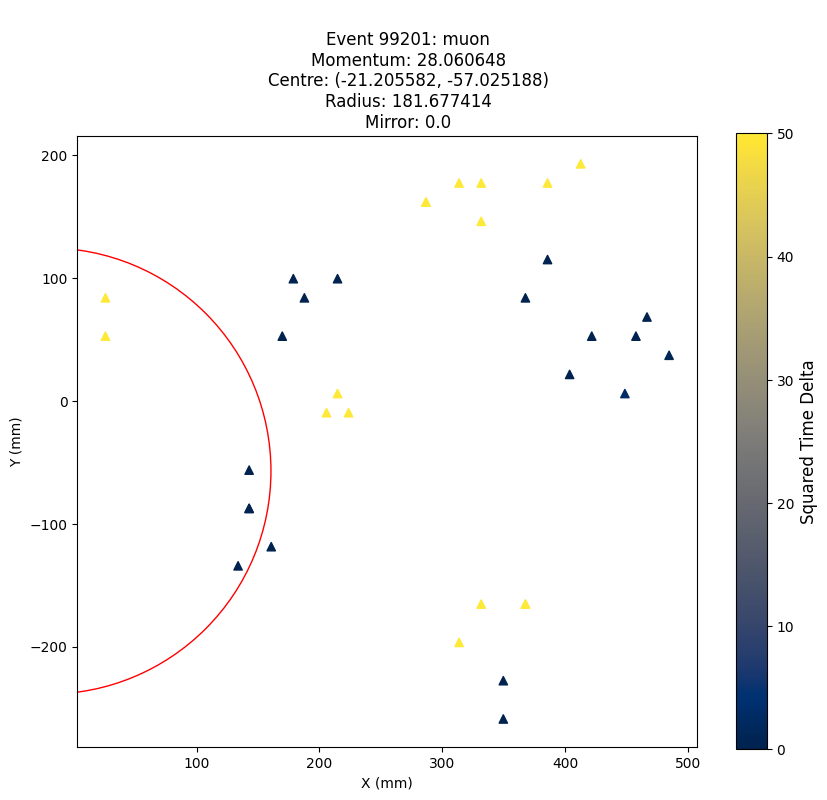

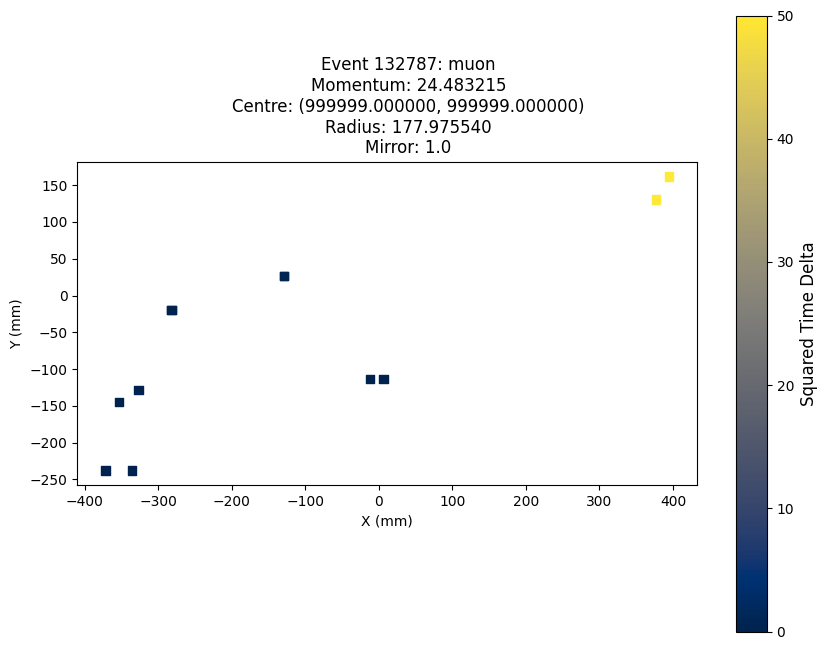

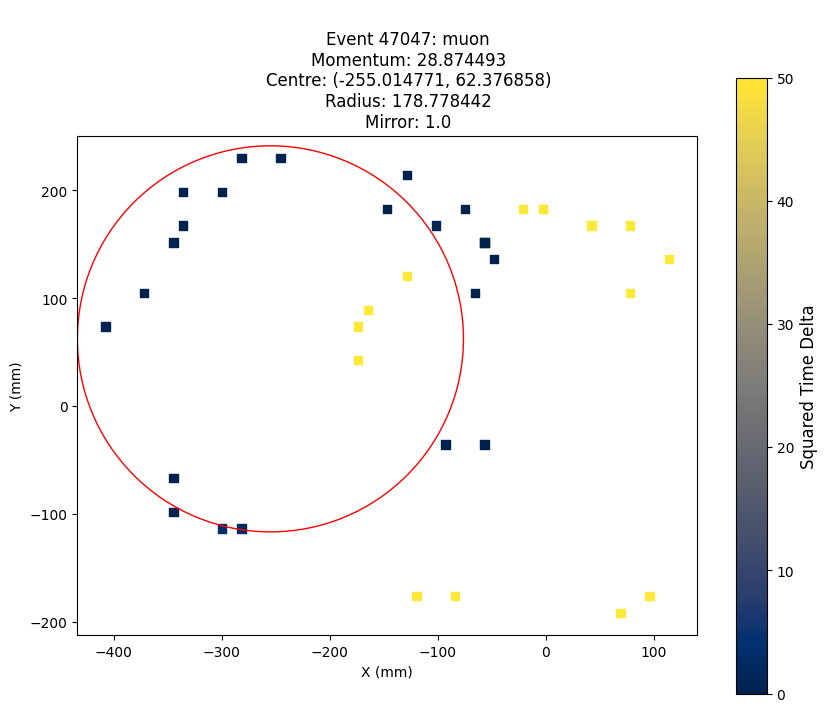

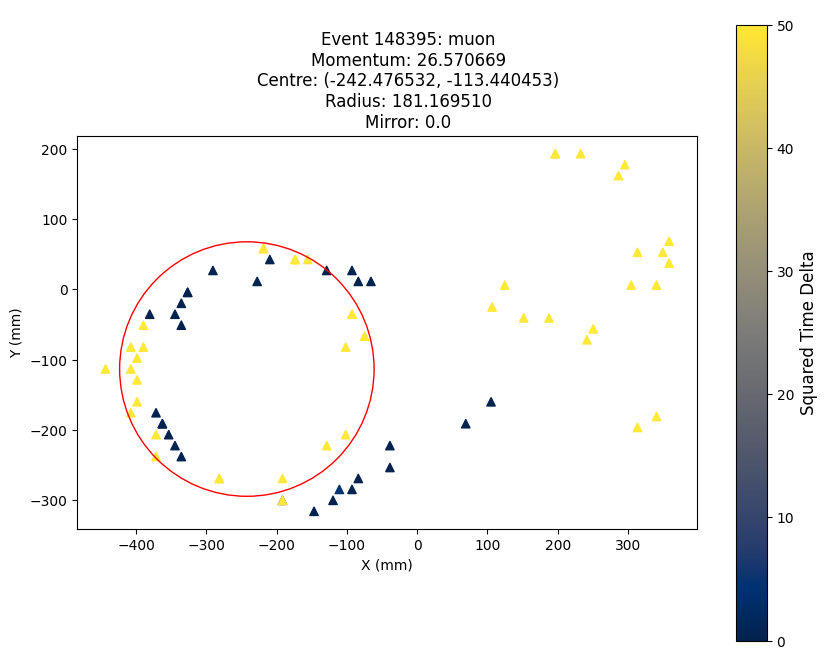

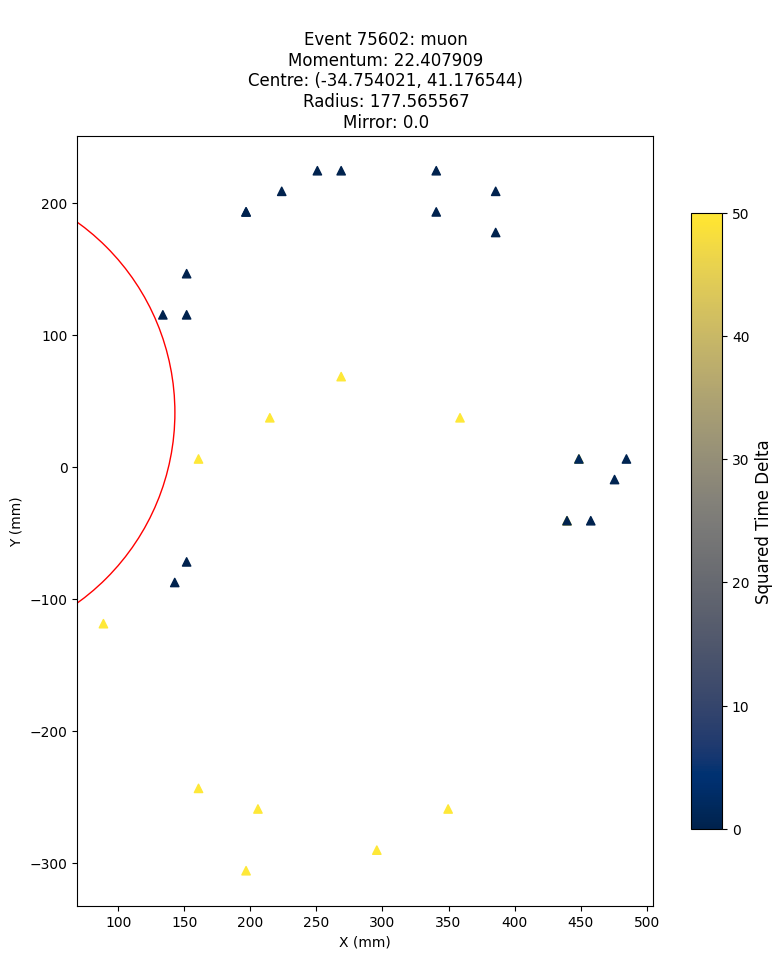

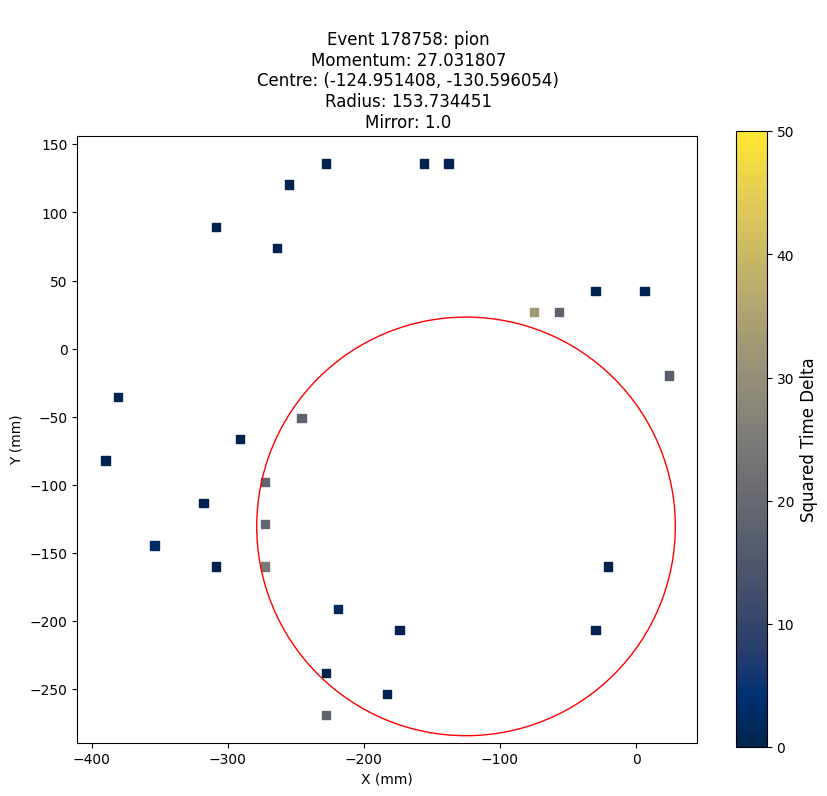

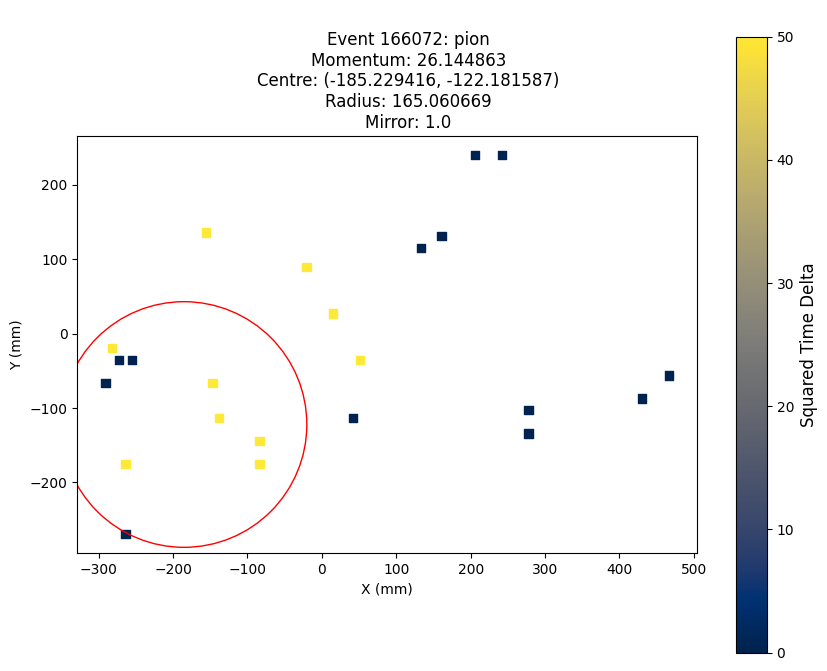

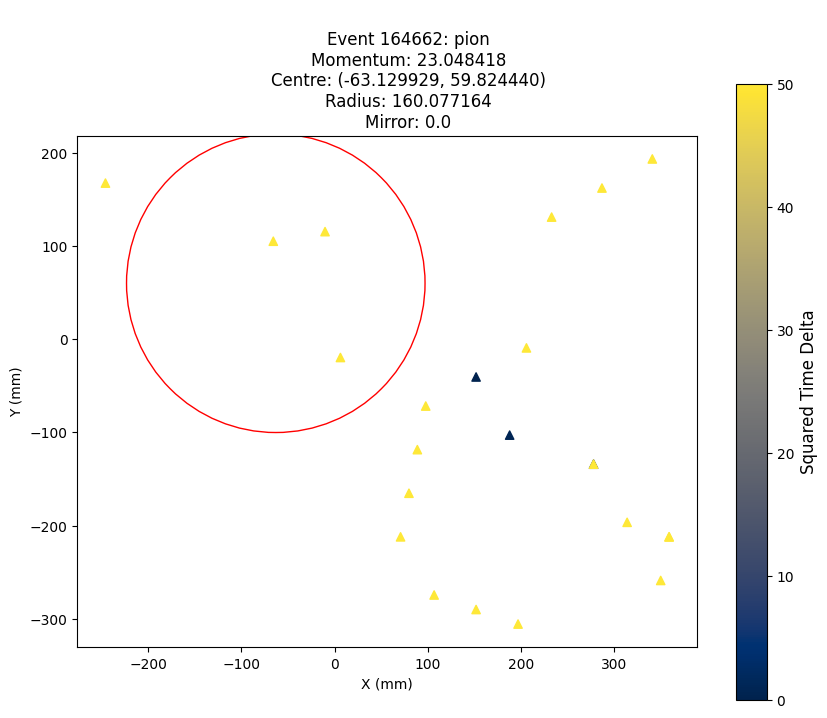

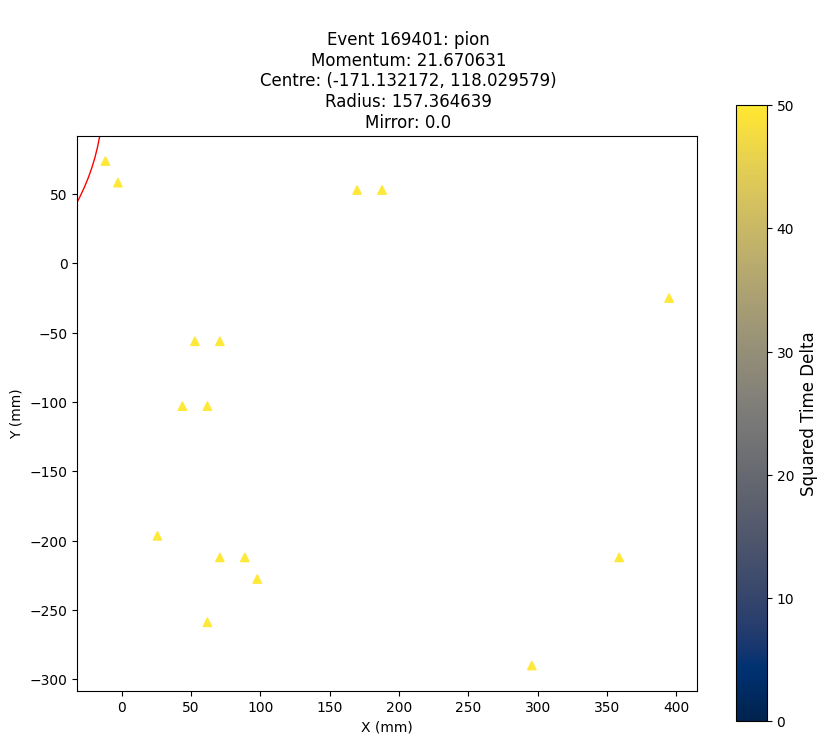

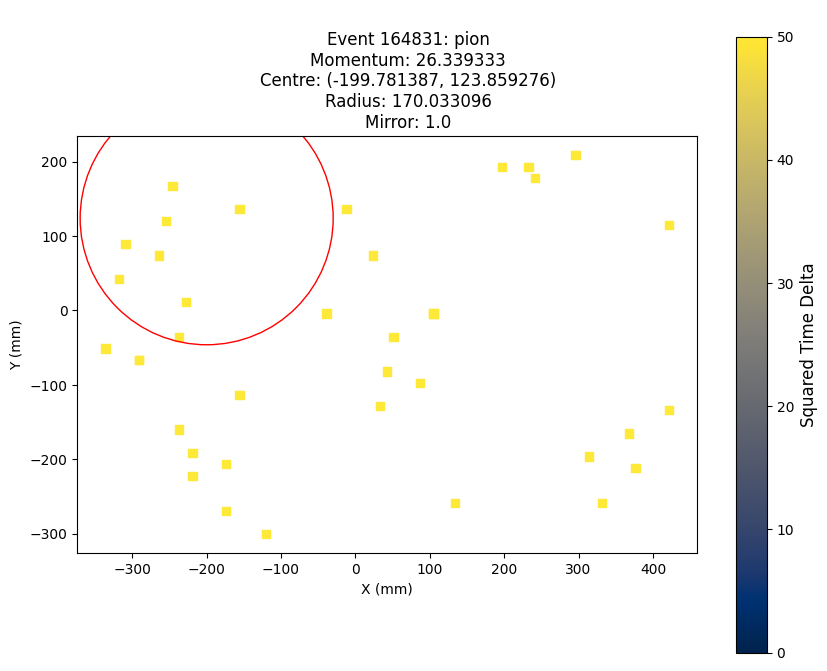

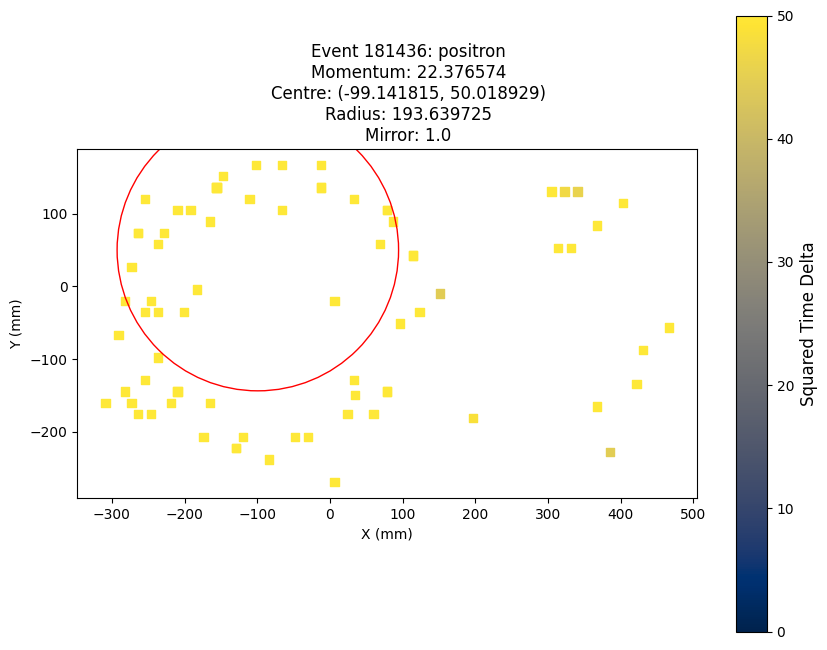

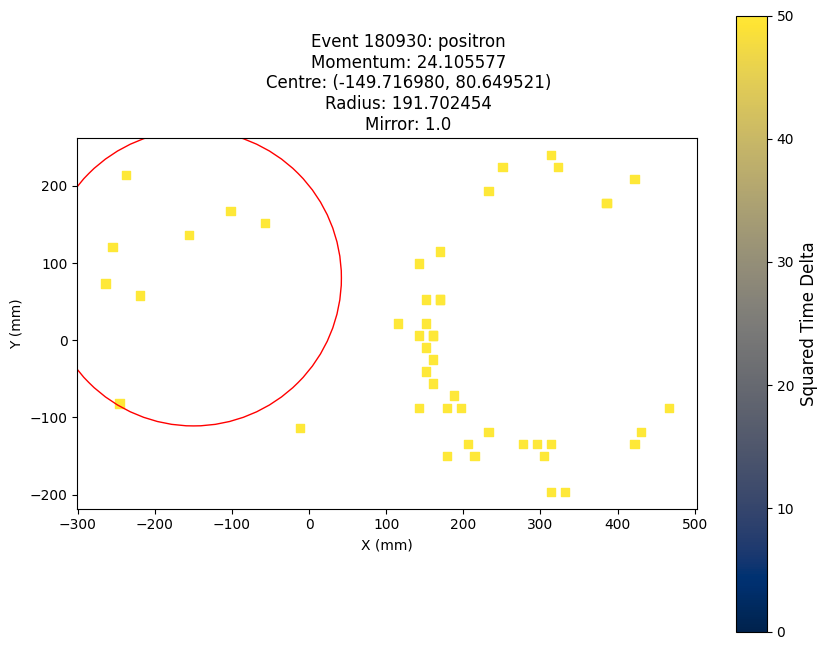

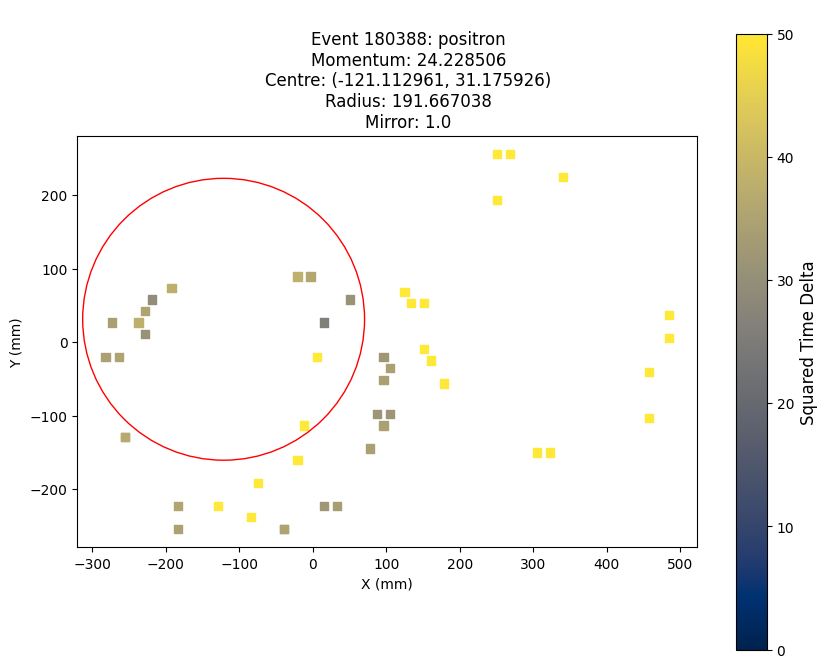

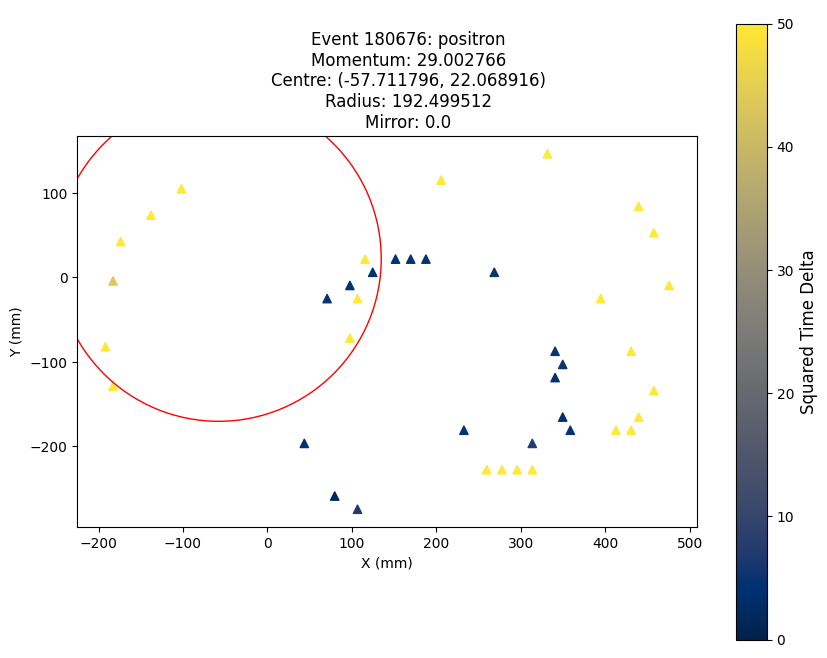

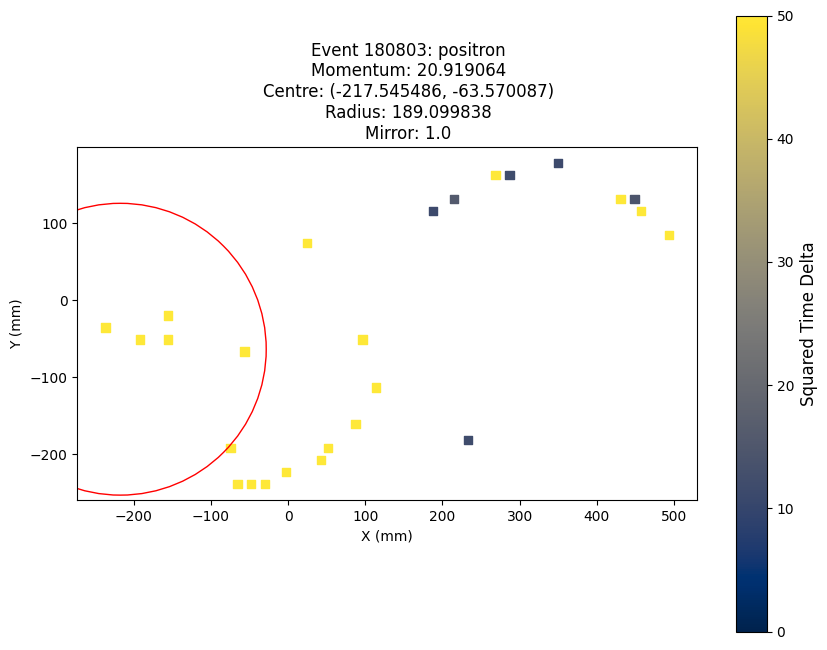

In [87]:
samples = get_class_samples(hits_df, n, seed, '20-29', True)
plot_rings(samples)

# 5 Ring Plots for Each Particle for Momentum bin '30-39'

In [49]:
# samples = get_class_samples(hits_df, n, seed, '30-39', True)
# plot_rings(samples)

# 5 Ring Plots for Each Particle for Momentum bin '40+'

In [50]:
# samples = get_class_samples(hits_df, n, seed, '40+', True)
# plot_rings(samples)